<a target="_blank" href="https://colab.research.google.com/github/ginal001/ML-2024-2025/blob/main/Lab9/Homework09.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# MNIST dataset
----------------------

In this workshop, we will construct an MLP network designed to a specific task of classification of MNIST dataset: a set of handwritten digits from *zero* to *nine*. MNIST stands for Modified National Institute of Standards and Technology database.

**You can read more about this dataset [here](https://colah.github.io/posts/2014-10-Visualizing-MNIST/#MNIST).**




# Multi Layer Perceptron Notation
---------------------------------

In this workshop we will be classifying 28 by 28 images into 10 classes. Thus, a four layer perceptron (our classificator) we will work further with can be defined as
$\hat f:\mathbb{R}^{28\cdot 28} \rightarrow \mathbb{R}^{10}$ defined as

$$\hat f \left(x; W_1, W_2, W_3, W_4, b_1, b_2, b_3, b_4 \right) =  W_4 \left[ W_3 \left[ W_2 \left[ W_1 x  + b_1 \right]_+  + b_2 \right]_+  + b_3 \right]_+ + b_4,$$

where matrices $W_1, \ldots, W_4$ are tensors of order two (matrices) with matching dimensions and bias terms $b_1, \ldots, b_4$ are tensors of order one (vectors) of matching dimensions, and we are using ReLU activation.

Note, that there is no nonlinear activation after the last layer in our neural network. **There is an implicit softmax applied while cross entropy loss is calculated by `torch.nn.functional`.**


# Reading MNIST Dataset to Play with It
--------------------

In [1]:
import torch
import torchvision
from matplotlib import pyplot

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=None)

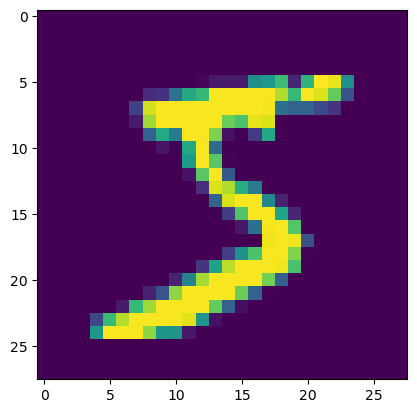

In [2]:
train_image, train_target = trainset[0]    #let us examine the 0-th sample
pyplot.imshow(train_image)
pyplot.show()

In [3]:
trainset.data[0]     #it will be shown in two rows, so a human has hard time classificating it

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [4]:
trainset[0][1]    #check if you classified it correctly in your mind

5

# Rereading the MNIST Data (Serious Preparation for Training)
------------------

In [5]:
(trainset.data.numpy().mean()/255.0, trainset.data.numpy().std()/255.0)   #MNIST datapoints are RGB integers 0-255

(np.float64(0.1306604762738429), np.float64(0.30810780385646264))

# Task
---------------

Why do we need to normalize the data, and not feed the NN with the 0-255 integers?

In [6]:
transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

## Visualizing Data


### Labels (Ground Truth Outputs)

In [7]:
for i, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        if i<5:
            print(i, "-th batch labels :", batch_labels)

0 -th batch labels : tensor([9, 1, 1,  ..., 8, 8, 9])
1 -th batch labels : tensor([4, 4, 1,  ..., 4, 6, 0])
2 -th batch labels : tensor([0, 5, 7,  ..., 3, 8, 6])
3 -th batch labels : tensor([5, 4, 5,  ..., 8, 1, 0])
4 -th batch labels : tensor([1, 2, 1,  ..., 1, 9, 4])


A single label is an entity of order zero (a constant), but batched labels are of order one. The first (and only) index is a sample index within a batch.

### Inputs

In [8]:
for i, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        if i==0:
            print(i, "-th batch inputs :", batch_inputs)

0 -th batch inputs : tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
     

OK, so each data image was initially a two dimensional image when we first saw it, but now the batches have order 4. The first index is a sample index within a batch, but a second index is always 0. This index represents a Channel number inserted here by `ToTensor()` transformation, always 0. As this order is one-dimensional, we can get rid of it, later, in training, in `Flatten` layer or by using `squeeze()` on a tensor.

# MLP Definition
-----------------

Your job now is to take the (fully functional) definition of the MLP structure and get rid off the Sequential layer.


In [9]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = torch.nn.Sequential(   #Sequential is a structure which allows stacking layers one on another in such a way,
                                          #that output from a preceding layer serves as input to the next layer
            torch.nn.Flatten(),   #change the last three orders in data (with dimensions 1, 28 and 28 respectively) into one order of dimensions (1*28*28)
            torch.nn.Linear(1*28*28, 1024),  #which is used as INPUT to the first Linear layer
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 2048),   #IMPORTANT! Please observe, that the OUTPUT dimension of a preceding layer is always equal to the INPUT dimension of the next layer.
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 256),
            torch.nn.ReLU(),            #ReLU (or a Sigmoid if you want) is a nonlinear function which is used in-between layers
            torch.nn.Linear(256, 10),
        )
        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):
        x = self.mlp(x)
        x = self.dropout(x)
        return x

# Training Loop
----------------------

In [10]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = MLP().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001.

net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(8):  #  an epoch is a training run through the whole data set

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)  #explicitly moving the data to the target device
        batch_labels = batch_labels.to(device)

        #batch_inputs.squeeze(1)     #alternatively if not for a Flatten layer, squeeze() could be used to remove the second order of the tensor, the Channel, which is one-dimensional (this index can be equal to 0 only)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the MLP object. Please note, that the last layer of the MLP is linear
                                            #and MLP doesn't apply
                                            #the nonlinear activation after the last layer
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.
                                ####You can experiment - comment this line and check, that the loss DOE

Working on cuda
epoch: 0 batch: 0 current batch loss: 2.303464412689209
epoch: 0 batch: 1 current batch loss: 2.0615832805633545
epoch: 0 batch: 2 current batch loss: 1.6267880201339722
epoch: 0 batch: 3 current batch loss: 1.2489776611328125
epoch: 0 batch: 4 current batch loss: 1.069415807723999
epoch: 0 batch: 5 current batch loss: 0.9230483770370483
epoch: 0 batch: 6 current batch loss: 0.7964382171630859
epoch: 0 batch: 7 current batch loss: 0.6710652112960815
epoch: 0 batch: 8 current batch loss: 0.7257379293441772
epoch: 0 batch: 9 current batch loss: 0.6012722253799438
epoch: 0 batch: 10 current batch loss: 0.5822268128395081
epoch: 0 batch: 11 current batch loss: 0.5132614374160767
epoch: 0 batch: 12 current batch loss: 0.4912824034690857
epoch: 0 batch: 13 current batch loss: 0.4295025169849396
epoch: 0 batch: 14 current batch loss: 0.4310319423675537
epoch: 0 batch: 15 current batch loss: 0.39525675773620605
epoch: 0 batch: 16 current batch loss: 0.3693750202655792
epoch: 0 

# Testing
----------------------

Correct the code below so it works.

In [11]:
good = 0
wrong = 0

net.eval()              #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing evaluation
with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
    for batch, data in enumerate(testloader): #batches in test are of size 1
        datapoint, label = data

        prediction = net(datapoint.to(device))                  #prediction has values representing the "prevalence" of the corresponding class
        classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

accuracy =  0.9819


# **Homework Assignment - *Do Androids Dream of Electric Sheep?***

-------------------------------------  

"Do Androids Dream of Electric Sheep?" – the famous title of Philip K. Dick’s novel – raises a fascinating question: if artificial intelligence could dream, what would it see?  

In this assignment, we explore a phenomenon known as **neural network dreams**, where instead of optimizing a neural network's weights, we **optimize the input itself** to achieve a desired classification outcome. Given a fully trained MNIST classification network, your goal is to manipulate its inputs so that it confidently predicts each digit from 0 to 9, starting from pure noise.  

## **Tasks Description**  

During this class we designed and trained a **MNIST classification neural network**, which takes a **batch of grayscale images** of size **$28 \times 28$** as input and outputs a probability distribution over the 10 digit classes (0–9). However, instead of using real MNIST images, you will **treat the input batch itself as a set of trainable parameters** and optimize it so that the network classifies each image as a specific digit.  

1. Your first task is to generate **a batch of 10 images**, where each image is
   classified as one of the digits **0, 1, 2, ..., 9**, starting from an initial batch of ten random Gaussian noise images.  

   Discuss the following question: do the generated images resemble real MNIST digits? Why or why not?  

2. Discuss, how you would approach a second task of
   generating an image that   
   bares similarity to two or more digits simultaneously. **Implement your idea to see the results.**

3. Third task: repeat the previous tasks with an additional L2 penalty on noise within the images. Experiment with adding `lambda_l2 * dreamed_input_batch.pow(2).mean()` loss term, with `lambda_l2` being the penalty cooefficient within an exponential progression, say from 0.001 to 10.0. Are the new digits recognized correctly? How does the penalty impact the digit quality? Explain.

### **Optimization Process for Task 1**  

1. Start with a **batch of 10 random Gaussian noise images** as the initial input and $(0, 1, 2, \ldots, 9)$ as the expected output batch of target digits.  
2. Define the objective: maximize the neural network's confidence for the corresponding target digit for each image in the batch.  
3. Use **gradient descent** to modify the pixels in each image, making the network classify each one as the assigned digit.  
4. Repeat until the network assigns suffieciently high confidence to each image’s target class.  

### **Implementation Details**  

- The neural network weights **must remain frozen** during optimization. You are modifying only the input images.  
- The loss function should be the **cross-entropy loss** between the predicted probabilities and the desired class labels (plus an optional weighted L2 penalty regularizing the images in task 3).


## **Points to Note**  

1. **Visualize** the optimization process: Save images of the generated inputs at different steps and plot the classification confidence evolution over iterations.  
3. **Document your findings** and explain the behavior you observe.  

## **Task & Deliverables**  

- A **Colab notebook** containing solutions for both tasks:
  - The full implementation.
  - Visualizations of the generated batch of images.
  - A written explanation of your observations.
- **Bonus:** If you create an **animation** showing the evolution of the input images during optimization, it will be considered a strong enhancement to your submission.
  - You can generate an animation programmatically (e.g., using Matplotlib or OpenCV).
  - Or, save image frames and use external tools to create a video.
  - Provide a **link** to any video files in the README.
- Upload your notebook and results to your **GitHub repository** for the course.
- In the **README**, include a **link** to the notebook.
- In the notebook, include **“Open in Colab”** badge so it can be launched directly.




# Solution

In [12]:
def plot_numbers(points):
    fig, axes = pyplot.subplots(1, 10, figsize=(15, 3))

    for i, ax in enumerate(axes):
        img = points[i].squeeze().detach().cpu().numpy()
        ax.imshow(img)      
        ax.set_title(f"{i}")            
        ax.axis('off')             

    pyplot.tight_layout()
    pyplot.show()



def train_input(net, lambda_l2 = 0, lr = 0.001, prob = 0.99999, plot = False, info = 2000, max_iter = 40000):
    for parameters in net.parameters():
        parameters.requires_grad = False
    
    points = torch.randn(10, 1, 28, 28).to(device)
    points.requires_grad = True
    
    true = torch.LongTensor(range(0,10)).to(device)
    
    optimizer = torch.optim.Adam([points], lr)

    epoch = 0
    
    while ( not all([torch.max(torch.nn.functional.softmax(net(points[number]), dim = 1)) > prob for number in range(0,10)]) ) and (epoch < max_iter):
    
        optimizer.zero_grad()
        preds = net(points)   
        loss = torch.nn.functional.cross_entropy(preds, true, reduction = "mean") + lambda_l2 * points.pow(2).mean()
    
        epoch += 1
        if epoch % info == 0:
            with torch.no_grad():
                print("Iteration", epoch, "current batch loss:", loss.item())
                print("Predicted value: ", [torch.argmax(torch.nn.functional.softmax(net(points[number]), dim = 1)).item() for number in range(0,10)], "\n", 
                  "Predicted probability: ", [round(torch.max(torch.nn.functional.softmax(net(points[number]), dim = 1)).item(), 6) for number in range(0,10)])

                if plot:
                    plot_numbers(points)
        
        loss.backward()     
        optimizer.step()     

    print("Iteration", epoch, "current batch loss:", loss.item())
    return points

Iteration 2000 current batch loss: 0.0019508406985551119
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.998617, 0.998478, 0.998088, 0.998796, 0.99715, 0.998889, 0.998252, 0.998411, 0.997149, 0.996684]


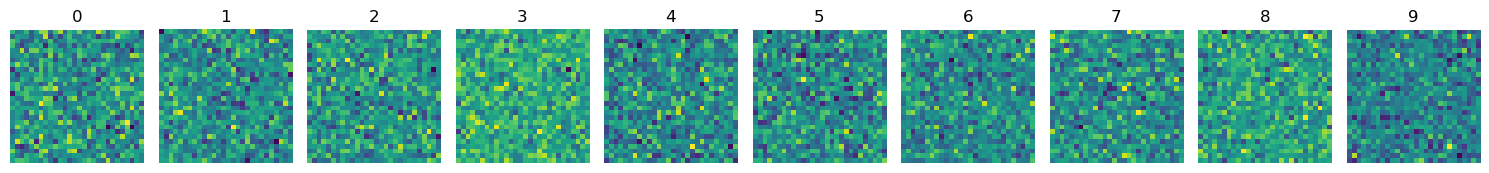

Iteration 4000 current batch loss: 0.0004488476552069187
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999673, 0.999704, 0.999541, 0.999731, 0.99931, 0.999743, 0.999633, 0.999646, 0.999333, 0.9992]


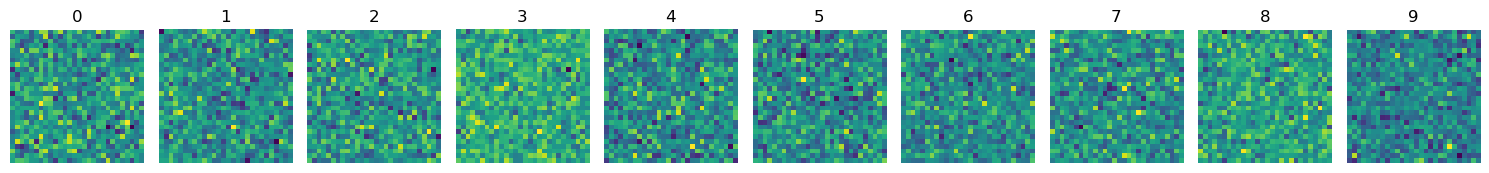

Iteration 6000 current batch loss: 0.00014408776769414544
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999892, 0.99991, 0.999852, 0.999916, 0.999765, 0.999915, 0.999891, 0.999893, 0.999788, 0.999738]


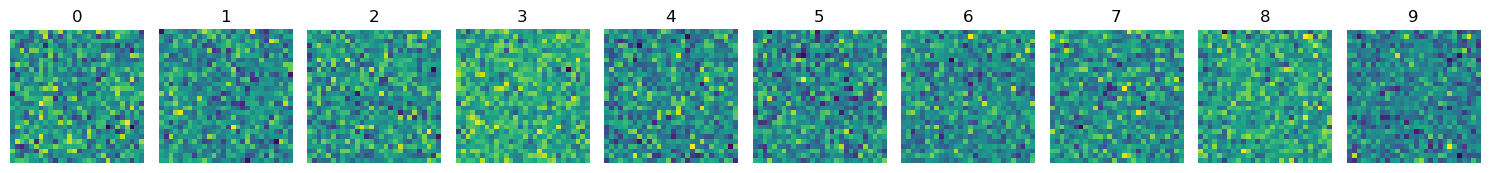

Iteration 8000 current batch loss: 5.0245191232534125e-05
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999961, 0.999969, 0.999949, 0.999971, 0.999916, 0.999969, 0.999964, 0.999964, 0.999925, 0.999908]


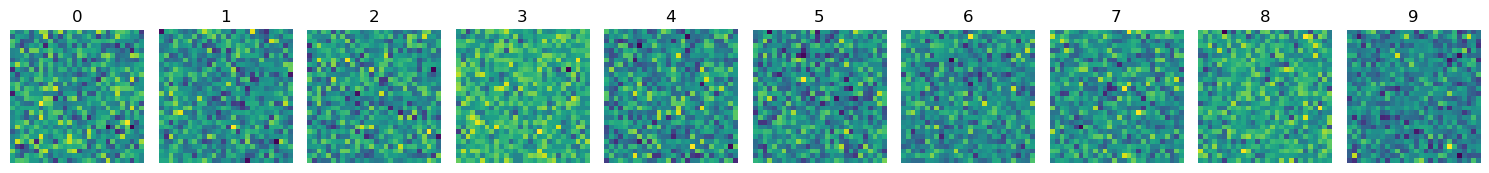

Iteration 10000 current batch loss: 1.8024245946435258e-05
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999986, 0.999989, 0.999982, 0.99999, 0.999971, 0.999989, 0.999987, 0.999987, 0.999973, 0.999966]


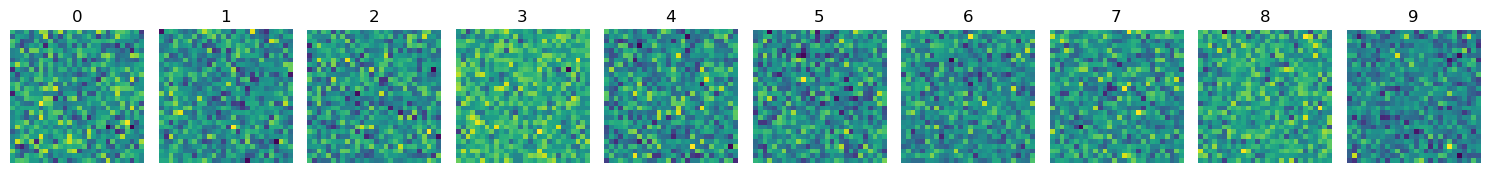

Iteration 12000 current batch loss: 6.36575123280636e-06
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999995, 0.999996, 0.999994, 0.999996, 0.99999, 0.999996, 0.999995, 0.999995, 0.999991, 0.999988]


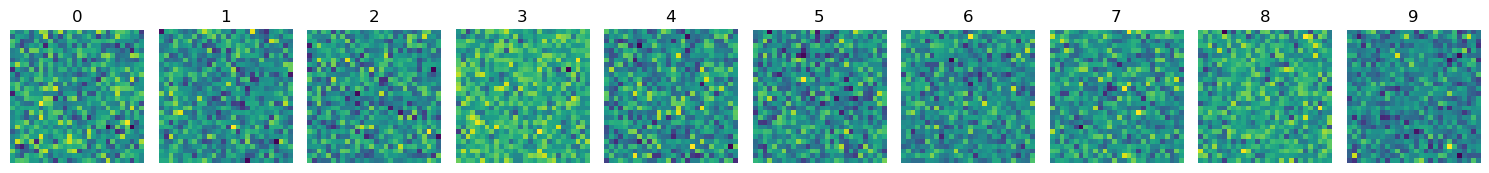

Iteration 12428 current batch loss: 5.149825483385939e-06


In [13]:
points = train_input(net, plot = True)

Iteration 2000 current batch loss: 0.010483788326382637
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.997907, 0.998367, 0.999263, 0.999934, 0.998432, 0.999943, 0.998683, 0.999928, 0.996878, 0.998008]


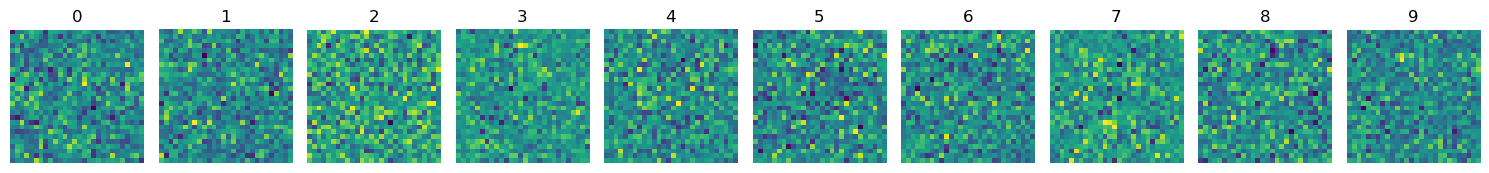

Iteration 4000 current batch loss: 0.008264984004199505
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999516, 0.999623, 0.999814, 0.999958, 0.999599, 0.999965, 0.999675, 0.999957, 0.999161, 0.99948]


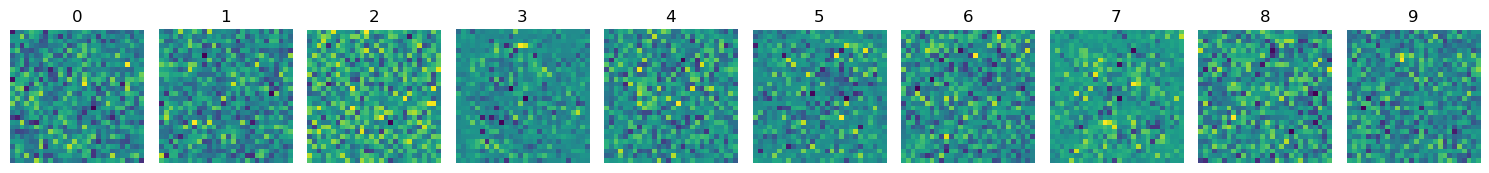

Iteration 6000 current batch loss: 0.00690860440954566
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999817, 0.999855, 0.999925, 0.999965, 0.99984, 0.999975, 0.999881, 0.999967, 0.999656, 0.999776]


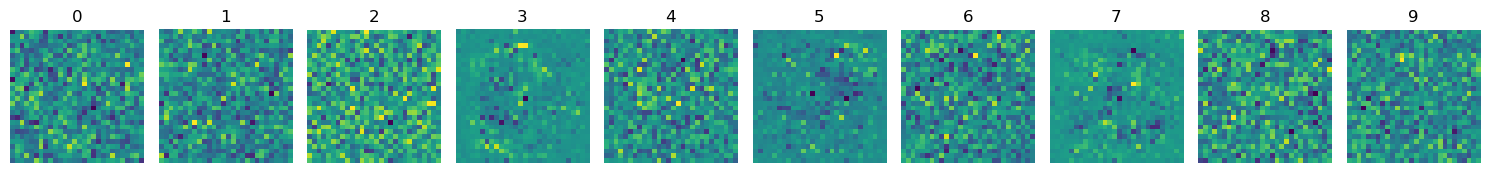

Iteration 8000 current batch loss: 0.005509254056960344
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999903, 0.999916, 0.999955, 0.999968, 0.999911, 0.999976, 0.999932, 0.999971, 0.999821, 0.999869]


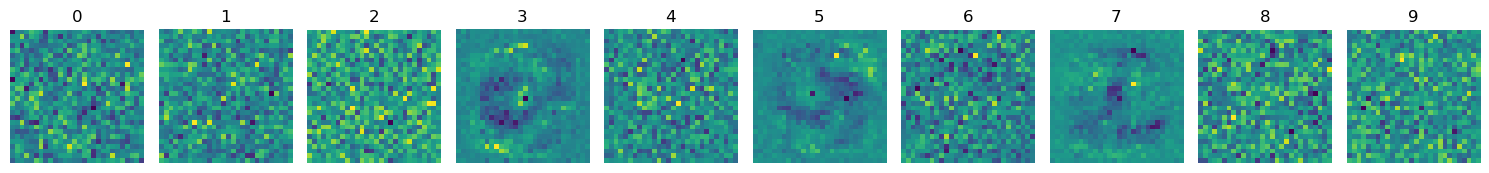

Iteration 10000 current batch loss: 0.0036535782273858786
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999928, 0.999932, 0.999962, 0.999968, 0.999929, 0.999975, 0.999951, 0.999971, 0.999871, 0.999908]


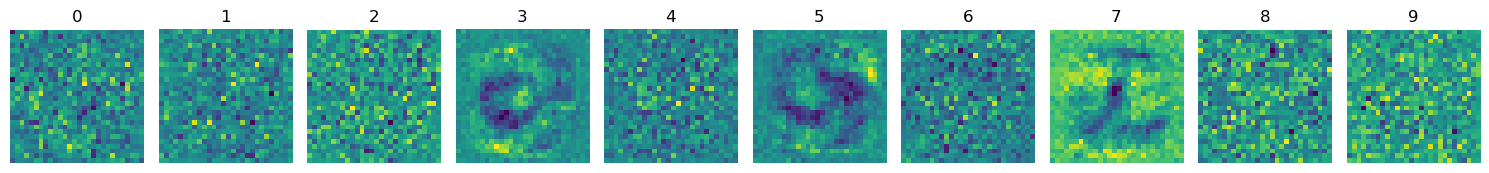

Iteration 12000 current batch loss: 0.0017579501727595925
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999942, 0.999945, 0.999965, 0.999968, 0.999936, 0.999975, 0.999956, 0.999971, 0.999902, 0.999926]


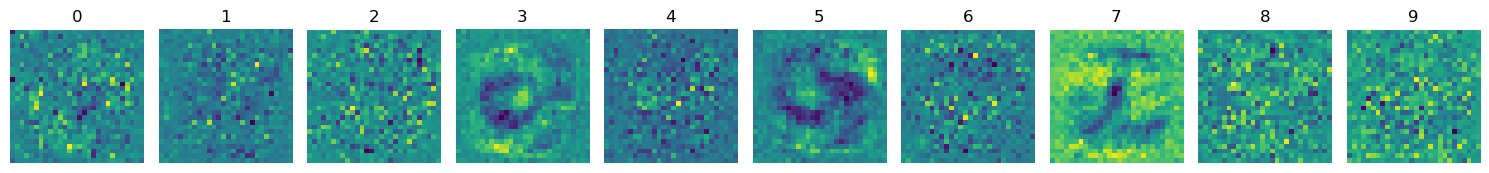

Iteration 14000 current batch loss: 0.0006197446491569281
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999952, 0.999951, 0.999967, 0.999968, 0.999947, 0.999976, 0.999958, 0.999971, 0.999933, 0.999936]


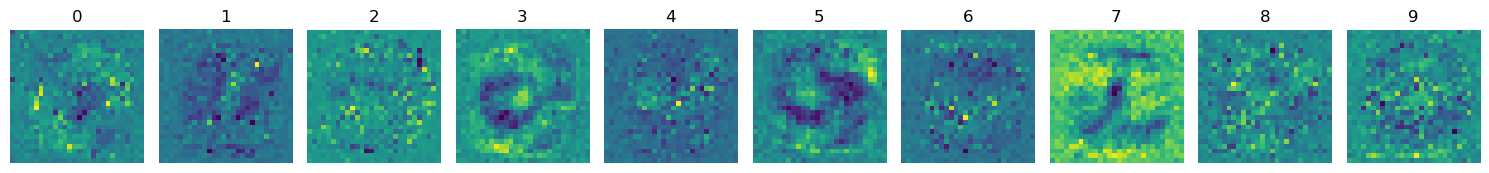

Iteration 16000 current batch loss: 0.0003061044553760439
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999954, 0.999953, 0.999968, 0.999968, 0.999952, 0.999976, 0.99996, 0.999971, 0.999942, 0.999941]


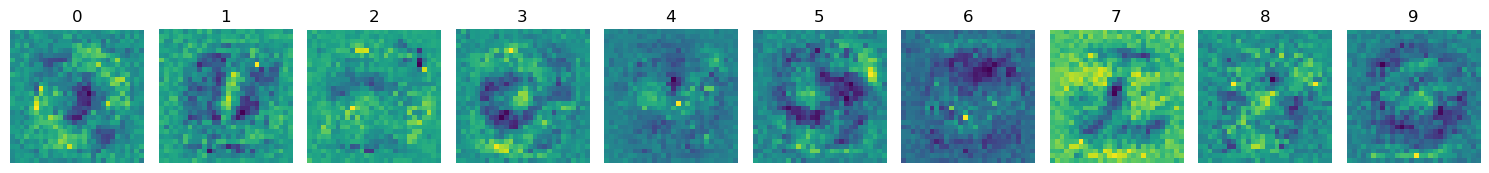

Iteration 18000 current batch loss: 0.0002794468018691987
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999954, 0.999954, 0.999968, 0.999968, 0.999954, 0.999975, 0.999961, 0.999971, 0.999943, 0.999941]


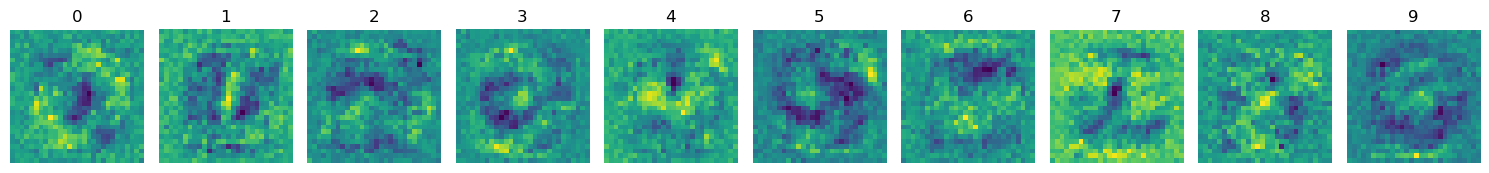

Iteration 20000 current batch loss: 0.00027900110580958426
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999954, 0.999954, 0.999968, 0.999968, 0.999954, 0.999976, 0.999961, 0.999971, 0.999943, 0.999941]


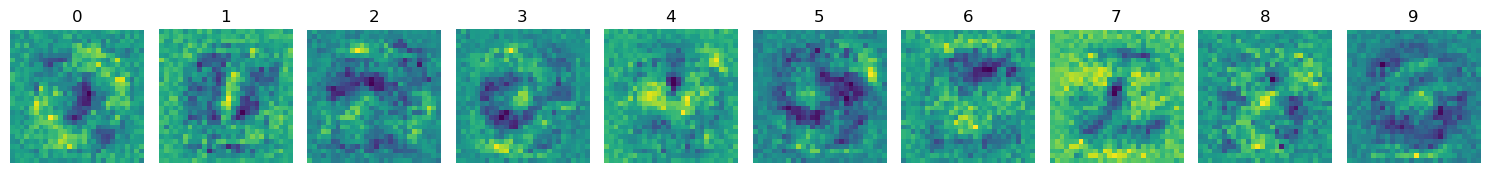

Iteration 22000 current batch loss: 0.0002790294820442796
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999954, 0.999954, 0.999968, 0.999968, 0.999954, 0.999975, 0.999961, 0.999971, 0.999943, 0.999941]


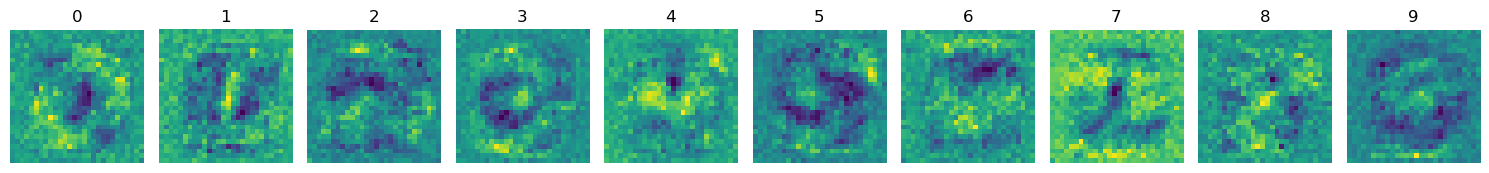

Iteration 24000 current batch loss: 0.00027904086164198816
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999954, 0.999954, 0.999969, 0.999968, 0.999954, 0.999975, 0.999961, 0.999971, 0.999943, 0.999941]


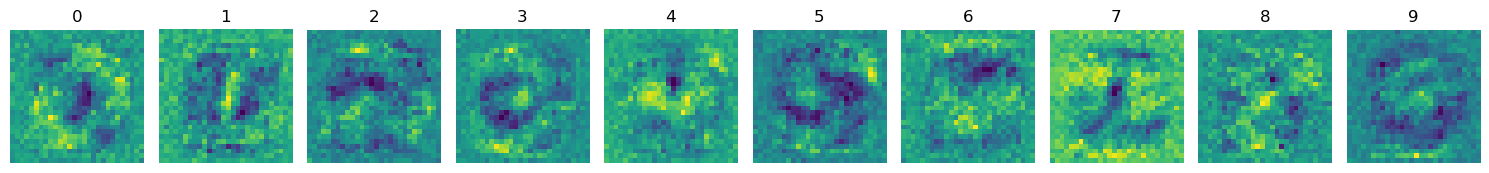

Iteration 26000 current batch loss: 0.0002790097496472299
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999954, 0.999954, 0.999968, 0.999968, 0.999954, 0.999976, 0.999961, 0.999971, 0.999943, 0.999941]


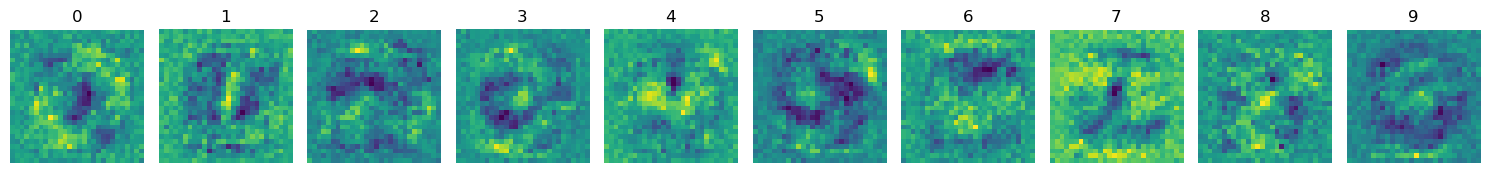

Iteration 28000 current batch loss: 0.0002789993886835873
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999954, 0.999954, 0.999968, 0.999968, 0.999954, 0.999976, 0.999961, 0.999971, 0.999943, 0.999941]


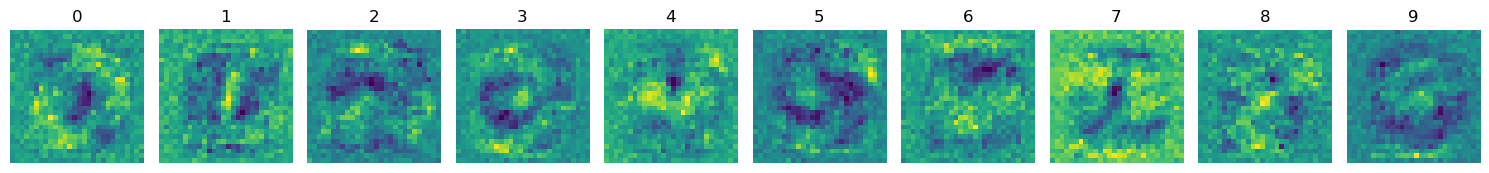

Iteration 30000 current batch loss: 0.0002790374855976552
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999954, 0.999953, 0.999968, 0.999968, 0.999954, 0.999975, 0.999961, 0.999971, 0.999943, 0.999941]


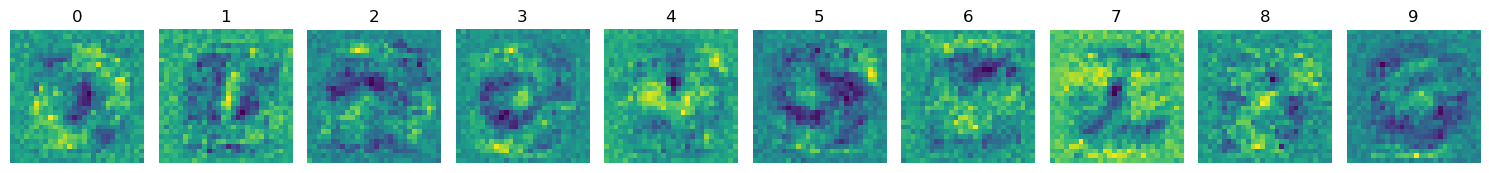

Iteration 32000 current batch loss: 0.0002790158614516258
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999954, 0.999954, 0.999969, 0.999968, 0.999954, 0.999975, 0.999961, 0.999971, 0.999943, 0.999941]


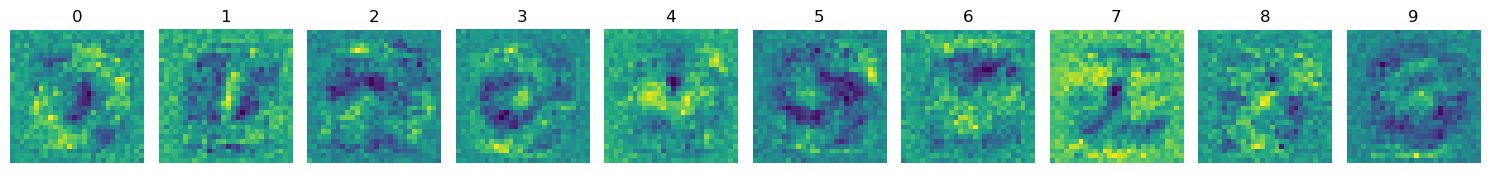

Iteration 34000 current batch loss: 0.0002790183643810451
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999954, 0.999954, 0.999968, 0.999968, 0.999954, 0.999976, 0.999961, 0.999971, 0.999943, 0.999941]


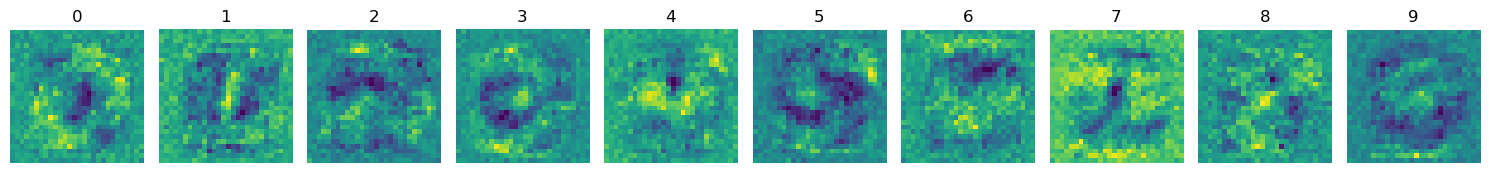

Iteration 36000 current batch loss: 0.0002790135913528502
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999954, 0.999954, 0.999968, 0.999968, 0.999954, 0.999976, 0.999961, 0.999971, 0.999943, 0.999941]


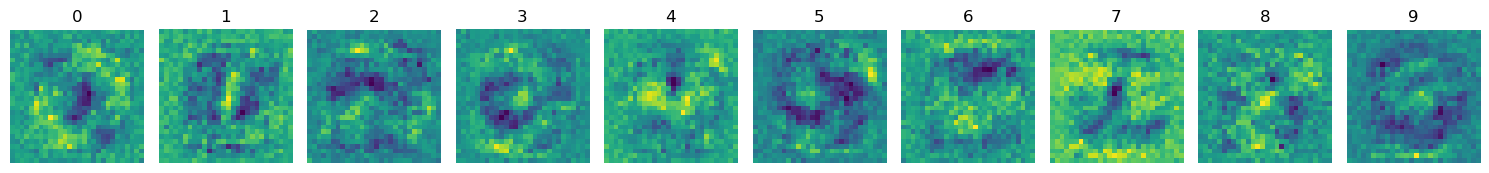

Iteration 38000 current batch loss: 0.00027902115834876895
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999954, 0.999954, 0.999968, 0.999968, 0.999954, 0.999975, 0.999961, 0.999971, 0.999943, 0.999941]


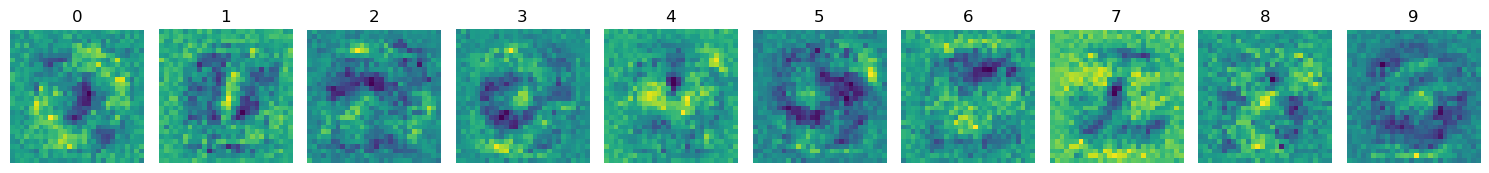

Iteration 40000 current batch loss: 0.00027900931308977306
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999954, 0.999954, 0.999968, 0.999968, 0.999954, 0.999976, 0.999961, 0.999971, 0.999943, 0.999941]


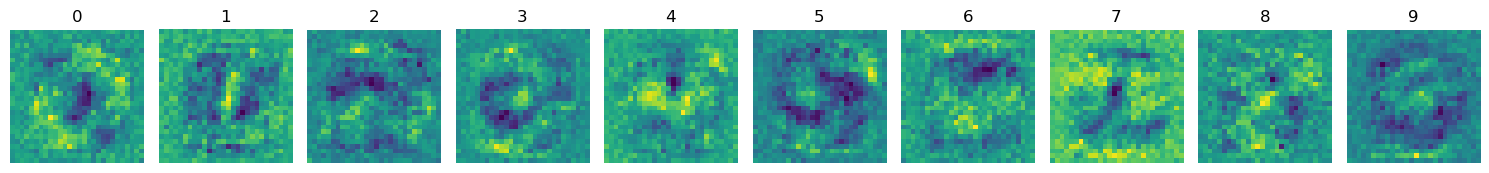

Iteration 40000 current batch loss: 0.00027900931308977306


In [14]:
points = train_input(net, lambda_l2 = 0.01, plot = True)

Iteration 2000 current batch loss: 0.09169810265302658
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99816, 0.998195, 0.998987, 0.99842, 0.997866, 0.999269, 0.998101, 0.998674, 0.997176, 0.997789]


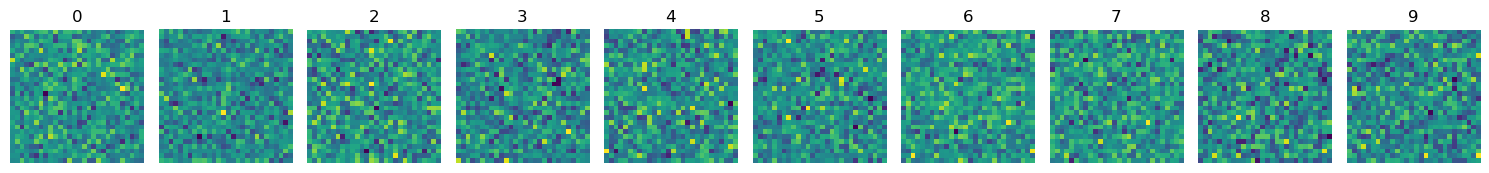

Iteration 4000 current batch loss: 0.06754129379987717
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999263, 0.999378, 0.999548, 0.999427, 0.999186, 0.999587, 0.999308, 0.999558, 0.998905, 0.999082]


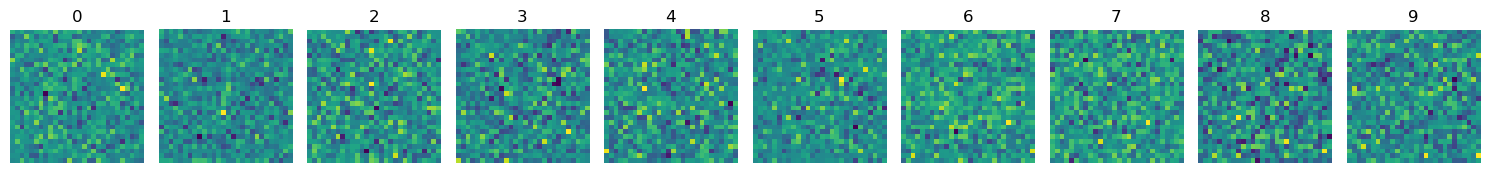

Iteration 6000 current batch loss: 0.03871774673461914
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.9994, 0.99951, 0.999629, 0.999545, 0.999395, 0.999734, 0.999546, 0.99968, 0.999303, 0.999366]


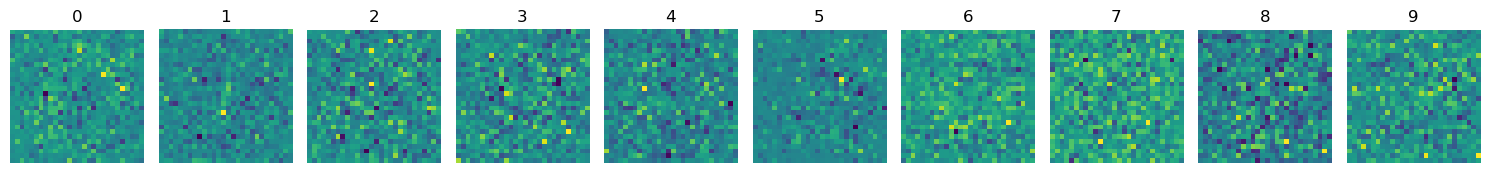

Iteration 8000 current batch loss: 0.01547330617904663
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999546, 0.999555, 0.99968, 0.999599, 0.999507, 0.999781, 0.999611, 0.999712, 0.999367, 0.999481]


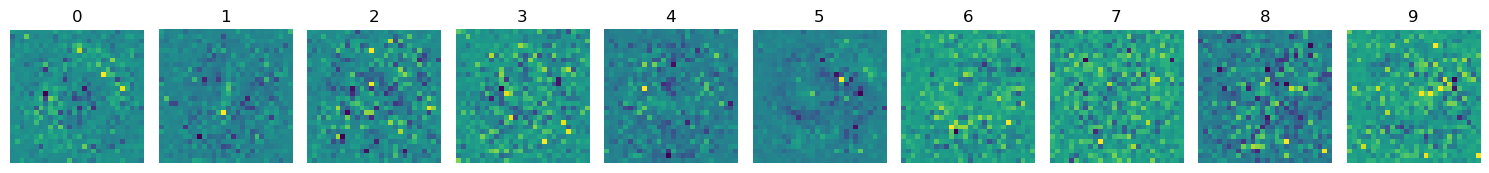

Iteration 10000 current batch loss: 0.004471564665436745
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999611, 0.999606, 0.999719, 0.999709, 0.999612, 0.999798, 0.999663, 0.999748, 0.999495, 0.999525]


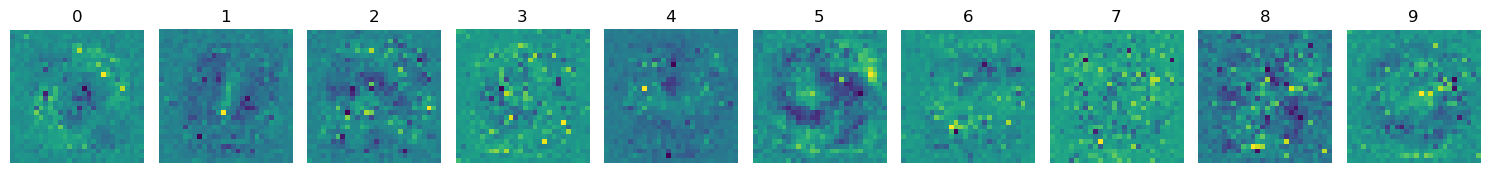

Iteration 12000 current batch loss: 0.0020949402824044228
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999626, 0.999621, 0.999737, 0.99973, 0.99963, 0.9998, 0.999682, 0.999762, 0.999534, 0.999528]


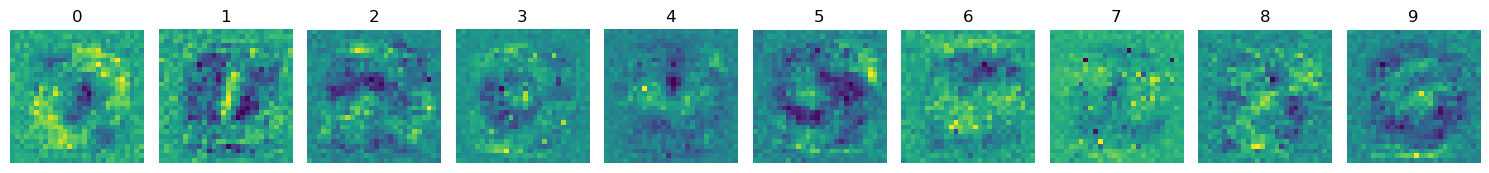

Iteration 14000 current batch loss: 0.0019369684159755707
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999628, 0.999623, 0.999741, 0.999739, 0.999632, 0.9998, 0.999685, 0.999767, 0.999537, 0.999526]


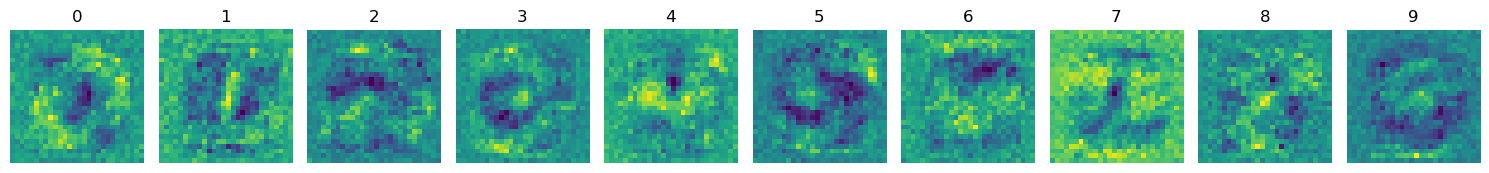

Iteration 16000 current batch loss: 0.0019359837751835585
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999628, 0.999623, 0.999741, 0.99974, 0.999632, 0.9998, 0.999685, 0.999767, 0.999537, 0.999526]


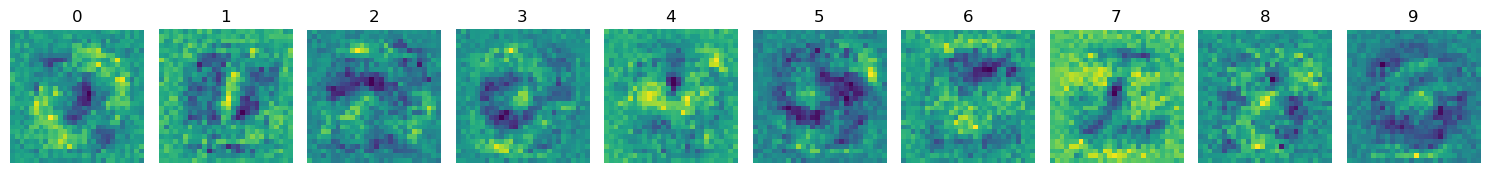

Iteration 18000 current batch loss: 0.0019360613077878952
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999628, 0.999622, 0.999741, 0.99974, 0.999631, 0.9998, 0.999685, 0.999767, 0.999537, 0.999526]


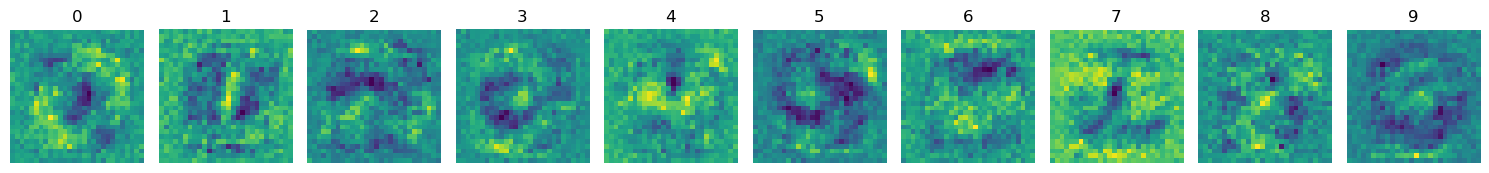

Iteration 20000 current batch loss: 0.0019360269652679563
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999628, 0.999623, 0.999742, 0.99974, 0.999632, 0.9998, 0.999685, 0.999767, 0.999537, 0.999527]


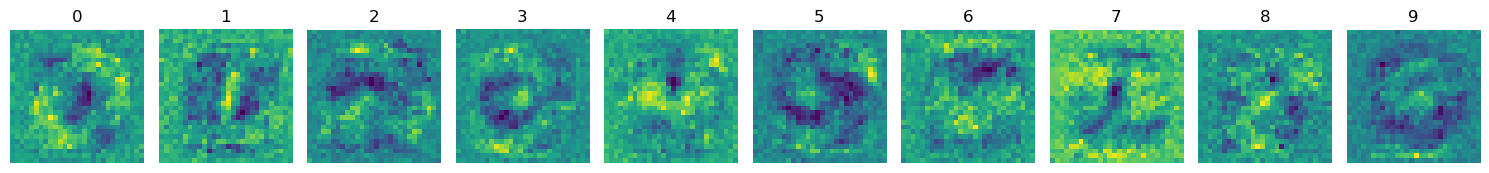

Iteration 22000 current batch loss: 0.0019360610749572515
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999628, 0.999623, 0.999741, 0.99974, 0.999632, 0.9998, 0.999685, 0.999767, 0.999537, 0.999527]


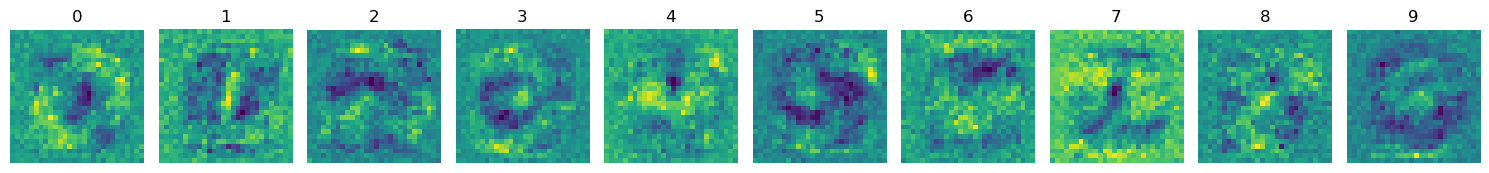

Iteration 24000 current batch loss: 0.0019360734149813652
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999628, 0.999623, 0.999741, 0.99974, 0.999632, 0.9998, 0.999684, 0.999767, 0.999537, 0.999527]


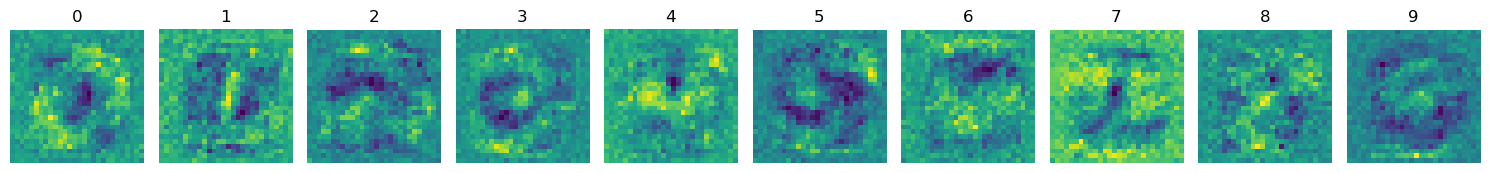

Iteration 26000 current batch loss: 0.0019360181177034974
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999628, 0.999623, 0.999741, 0.99974, 0.999632, 0.9998, 0.999685, 0.999767, 0.999537, 0.999527]


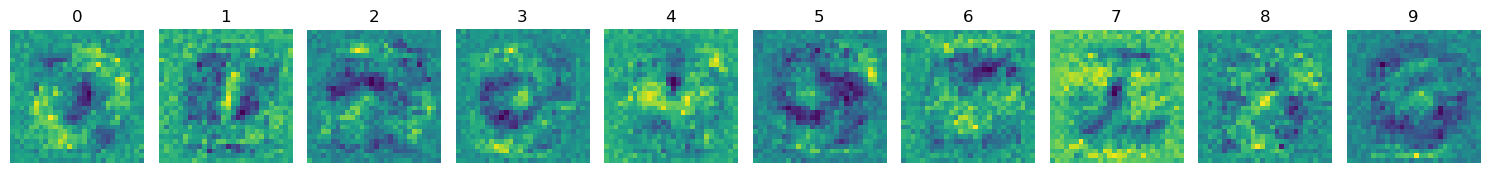

Iteration 28000 current batch loss: 0.0019360636360943317
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999628, 0.999622, 0.999741, 0.99974, 0.999632, 0.9998, 0.999685, 0.999767, 0.999537, 0.999526]


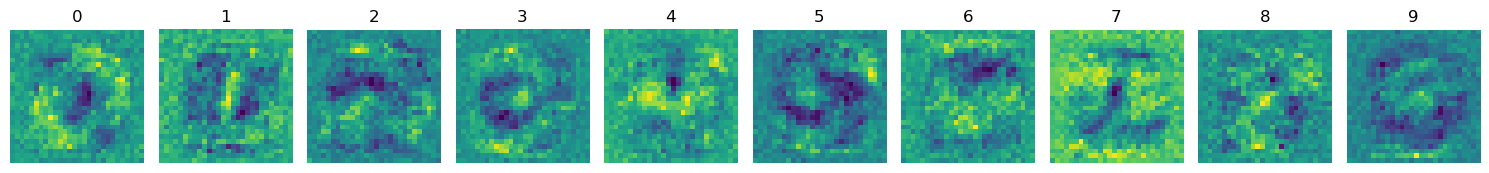

Iteration 30000 current batch loss: 0.0019360522273927927
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999628, 0.999623, 0.999741, 0.99974, 0.999632, 0.9998, 0.999685, 0.999767, 0.999537, 0.999527]


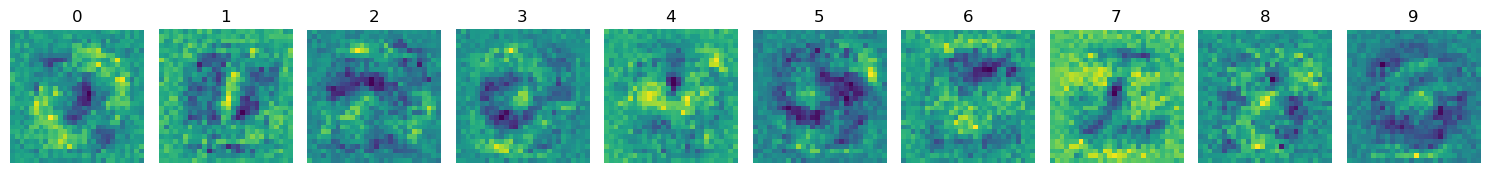

Iteration 32000 current batch loss: 0.0019360666628926992
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999628, 0.999623, 0.999741, 0.99974, 0.999632, 0.9998, 0.999685, 0.999767, 0.999537, 0.999526]


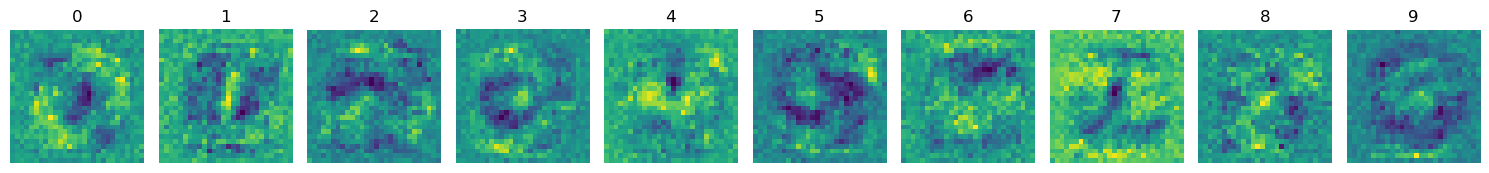

Iteration 34000 current batch loss: 0.0019360813312232494
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999628, 0.999623, 0.999741, 0.99974, 0.999632, 0.9998, 0.999685, 0.999767, 0.999537, 0.999527]


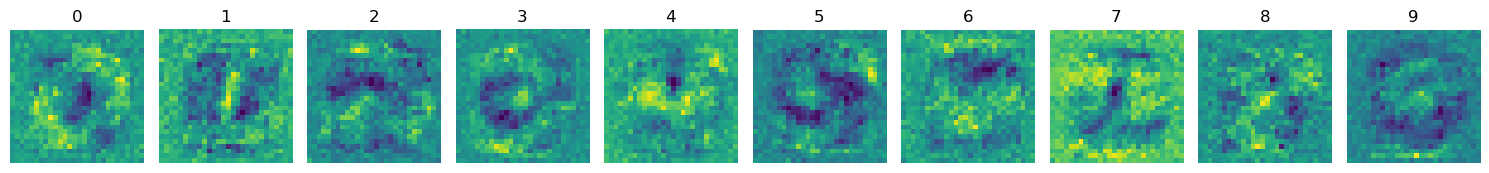

Iteration 36000 current batch loss: 0.0019360710866749287
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999628, 0.999622, 0.999741, 0.99974, 0.999632, 0.999801, 0.999685, 0.999767, 0.999537, 0.999526]


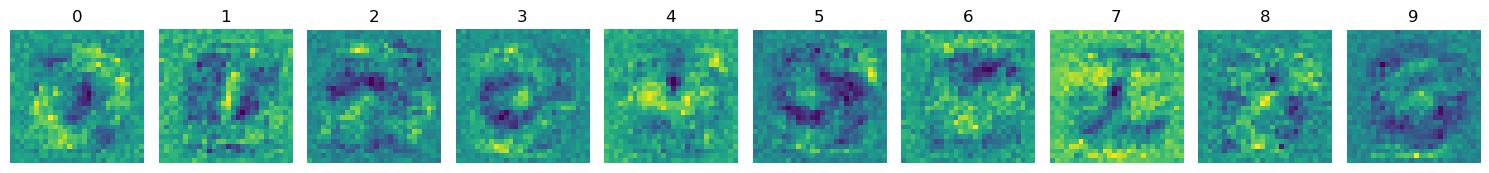

Iteration 38000 current batch loss: 0.001936117885634303
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999628, 0.999622, 0.999741, 0.99974, 0.999632, 0.9998, 0.999685, 0.999767, 0.999537, 0.999527]


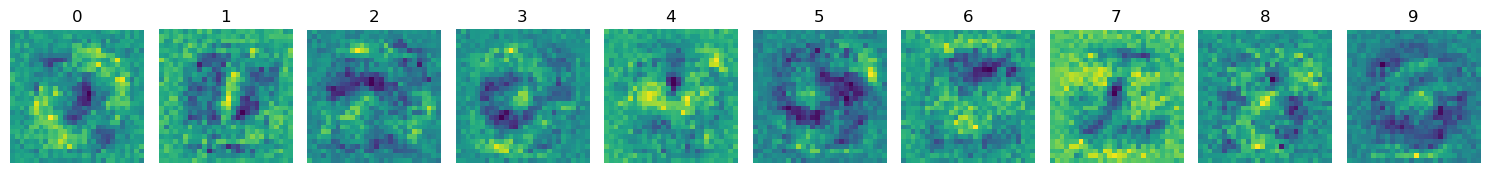

Iteration 40000 current batch loss: 0.0019360404694452882
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999628, 0.999623, 0.999741, 0.99974, 0.999632, 0.9998, 0.999685, 0.999767, 0.999537, 0.999527]


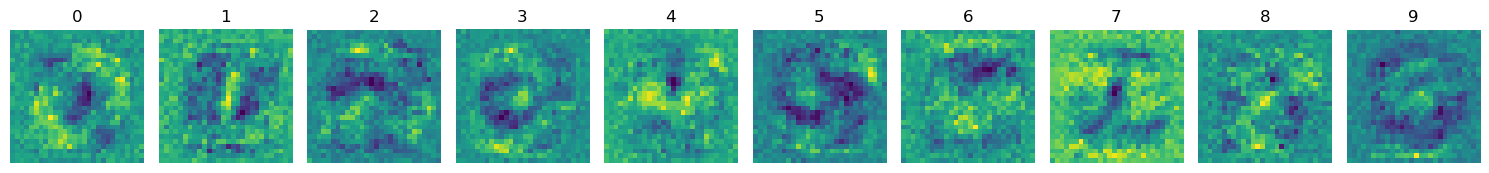

Iteration 40000 current batch loss: 0.0019360404694452882


In [15]:
points = train_input(net, lambda_l2 = 0.1, plot = True)

Iteration 2000 current batch loss: 0.45626187324523926
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.996035, 0.994205, 0.997153, 0.995385, 0.995186, 0.99822, 0.995357, 0.996853, 0.994927, 0.995246]


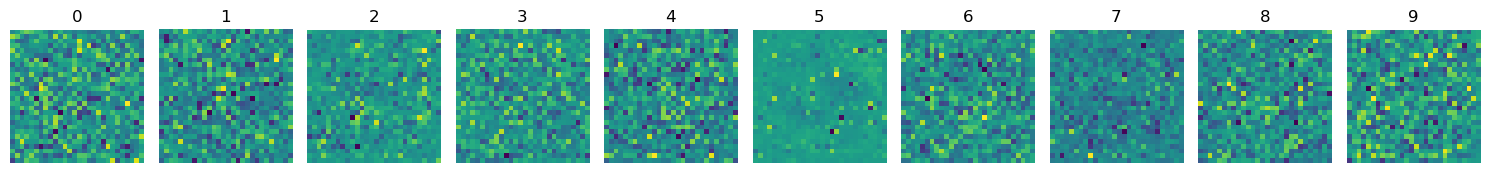

Iteration 4000 current batch loss: 0.13269062340259552
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.996432, 0.995904, 0.997778, 0.996893, 0.996154, 0.998421, 0.996661, 0.997992, 0.995639, 0.995401]


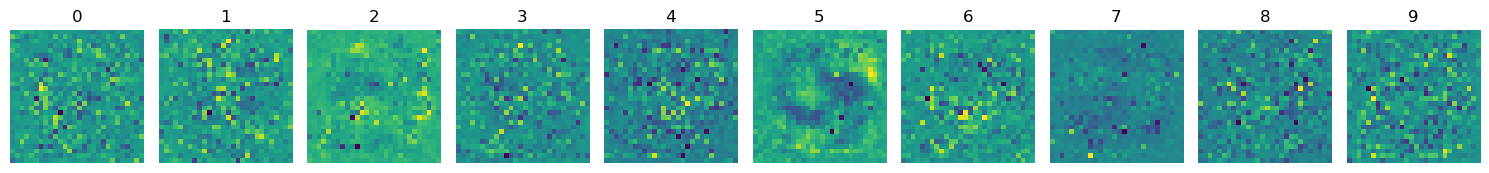

Iteration 6000 current batch loss: 0.029482262209057808
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.996896, 0.996658, 0.997928, 0.997778, 0.996857, 0.998424, 0.997482, 0.998209, 0.995946, 0.996042]


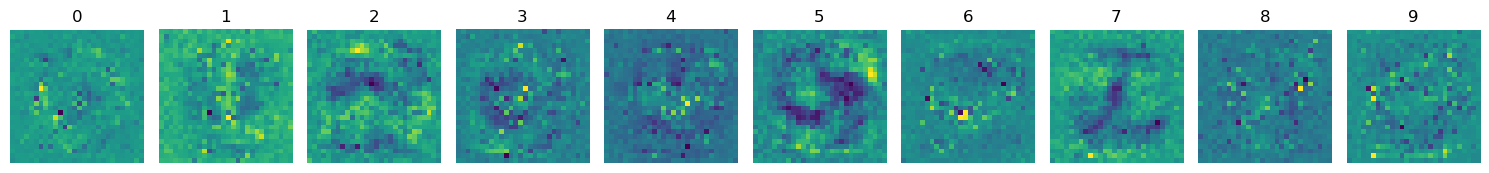

Iteration 8000 current batch loss: 0.013450116850435734
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99707, 0.996909, 0.997967, 0.997952, 0.997202, 0.998422, 0.997524, 0.998227, 0.996276, 0.996295]


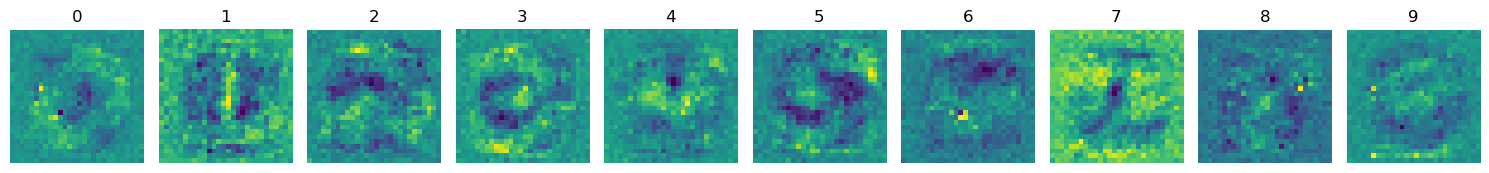

Iteration 10000 current batch loss: 0.012631644494831562
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.997093, 0.996912, 0.997968, 0.99797, 0.997205, 0.998422, 0.997535, 0.998227, 0.99636, 0.996339]


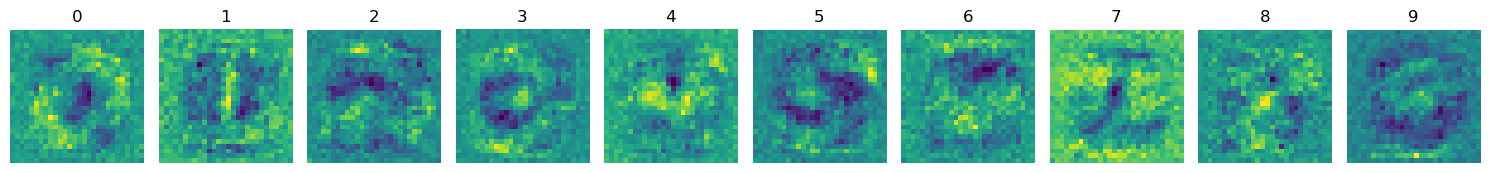

Iteration 12000 current batch loss: 0.012625452131032944
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.997094, 0.996913, 0.997969, 0.997971, 0.997206, 0.998421, 0.997533, 0.998227, 0.996367, 0.996341]


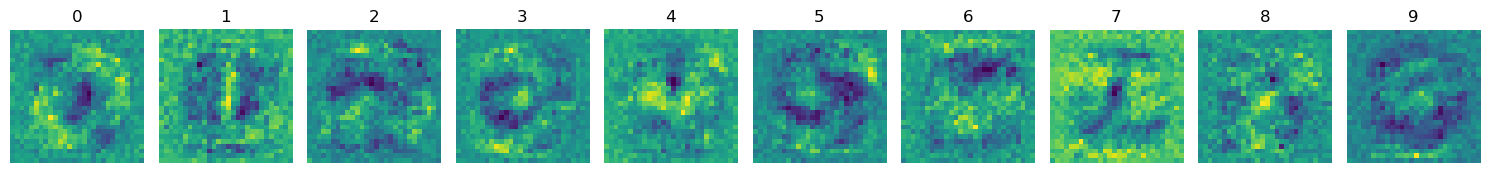

Iteration 14000 current batch loss: 0.012621501460671425
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.997094, 0.996911, 0.997967, 0.997969, 0.997208, 0.998423, 0.997535, 0.998226, 0.996379, 0.996341]


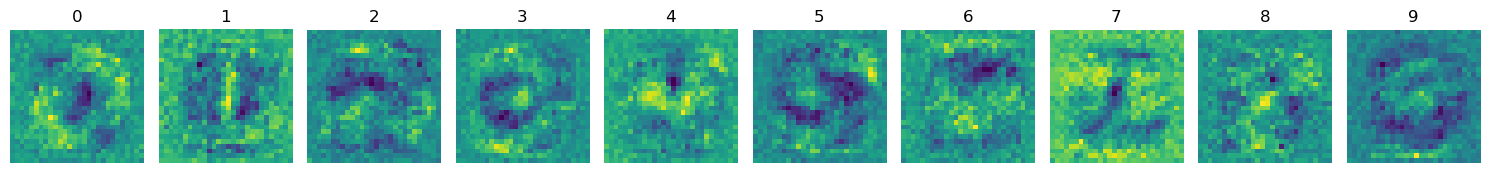

Iteration 16000 current batch loss: 0.012621967121958733
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.997093, 0.996912, 0.997969, 0.99797, 0.997209, 0.998422, 0.997532, 0.998227, 0.996377, 0.996339]


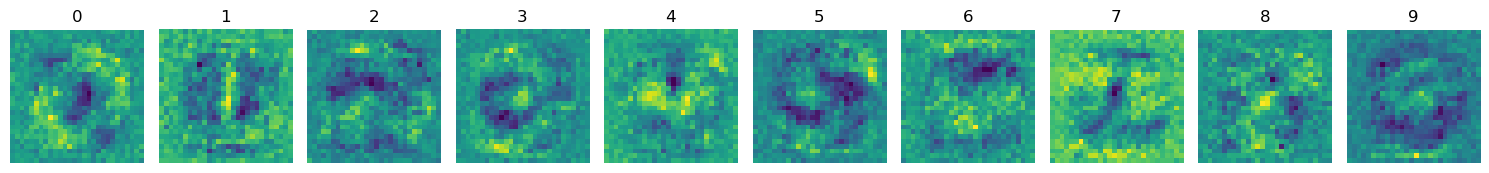

Iteration 18000 current batch loss: 0.012621928006410599
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.997093, 0.996912, 0.997969, 0.997969, 0.997208, 0.998423, 0.997535, 0.998227, 0.996378, 0.99634]


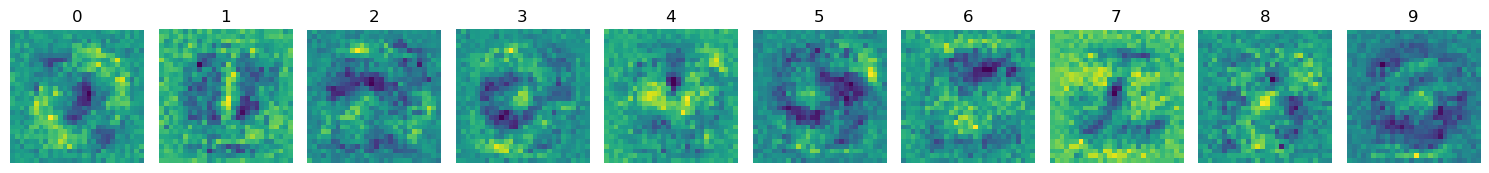

Iteration 20000 current batch loss: 0.012622231617569923
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.997093, 0.996912, 0.997971, 0.99797, 0.997205, 0.998421, 0.997532, 0.998225, 0.996377, 0.996342]


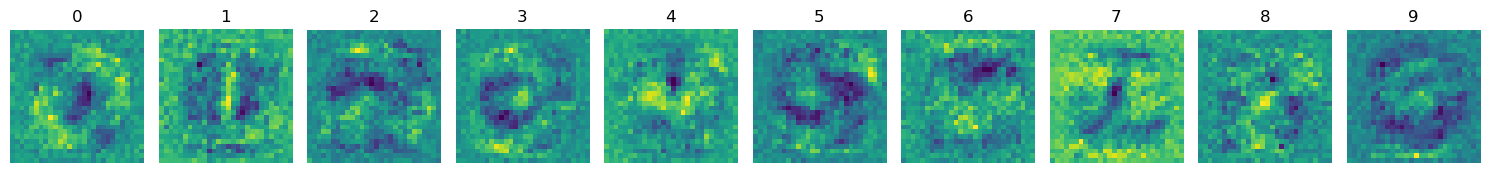

Iteration 22000 current batch loss: 0.012622295878827572
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.997095, 0.99691, 0.997966, 0.99797, 0.997203, 0.998423, 0.997534, 0.998227, 0.996378, 0.996342]


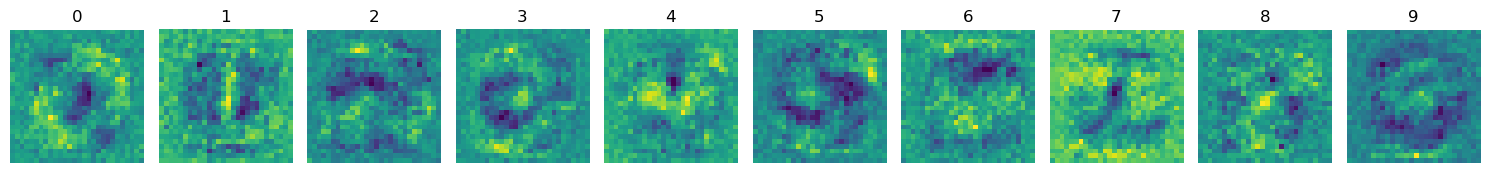

Iteration 24000 current batch loss: 0.012622200883924961
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99709, 0.996911, 0.997968, 0.99797, 0.997209, 0.998425, 0.997535, 0.998227, 0.996378, 0.996339]


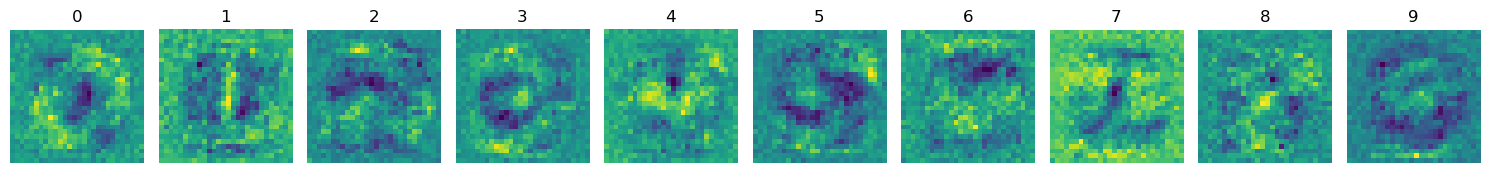

Iteration 26000 current batch loss: 0.01262196060270071
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.997093, 0.996914, 0.997967, 0.99797, 0.997208, 0.998423, 0.997533, 0.998228, 0.996378, 0.996337]


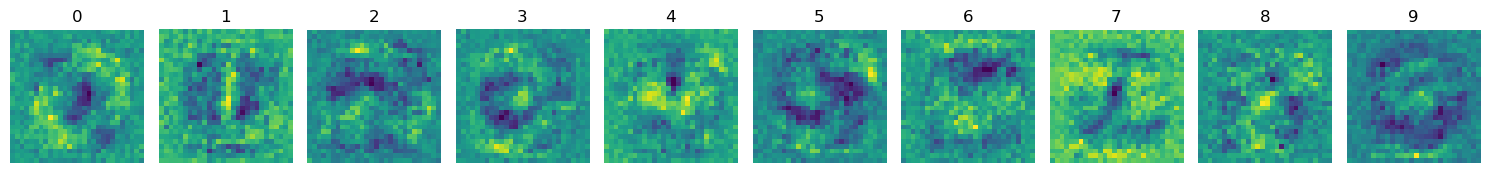

Iteration 28000 current batch loss: 0.012622000649571419
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.997094, 0.996914, 0.99797, 0.997971, 0.997207, 0.998424, 0.997535, 0.998226, 0.996379, 0.99634]


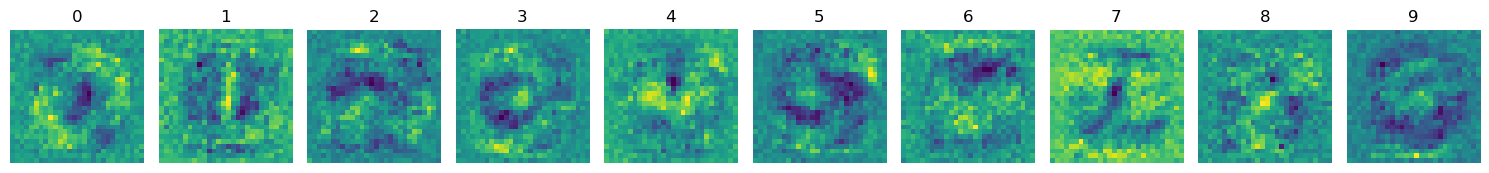

Iteration 30000 current batch loss: 0.012622129172086716
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.997093, 0.996909, 0.997967, 0.997971, 0.997205, 0.998423, 0.997534, 0.998227, 0.996379, 0.99634]


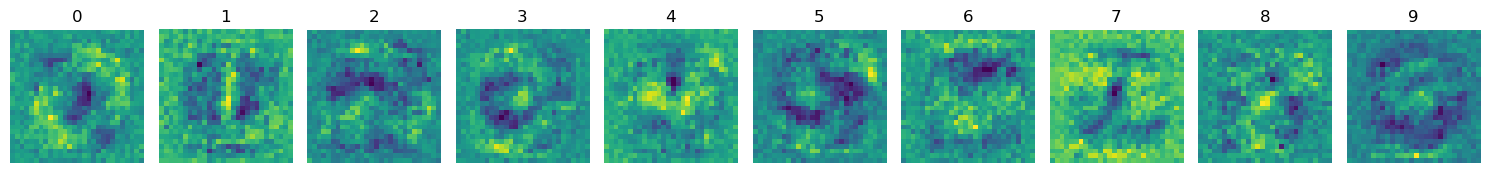

Iteration 32000 current batch loss: 0.012622270733118057
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.997092, 0.996914, 0.997968, 0.997968, 0.997204, 0.998425, 0.997536, 0.998227, 0.996379, 0.99634]


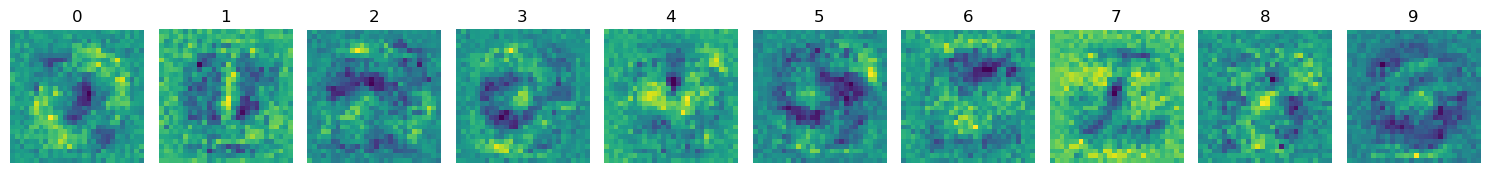

Iteration 34000 current batch loss: 0.012622211128473282
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.997092, 0.996913, 0.997967, 0.997968, 0.997206, 0.998423, 0.997534, 0.998227, 0.996378, 0.99634]


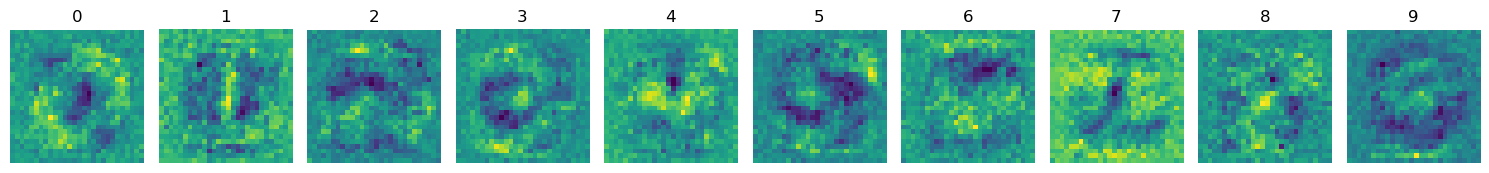

Iteration 36000 current batch loss: 0.012622294947504997
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.997091, 0.996912, 0.997969, 0.997967, 0.997212, 0.99842, 0.997534, 0.998226, 0.996377, 0.996343]


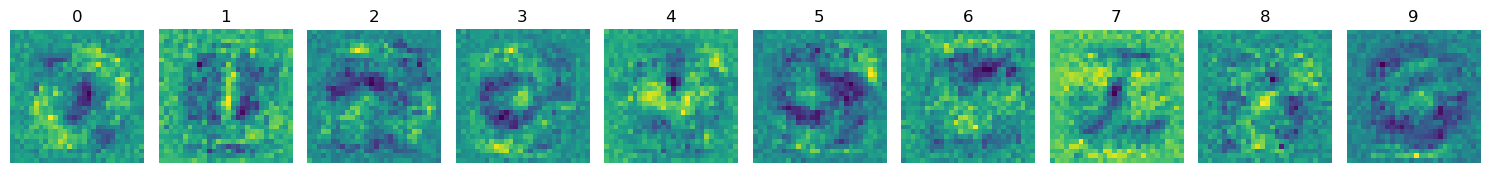

Iteration 38000 current batch loss: 0.012622630223631859
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.997094, 0.996911, 0.997967, 0.99797, 0.997208, 0.998421, 0.997532, 0.998226, 0.996377, 0.996338]


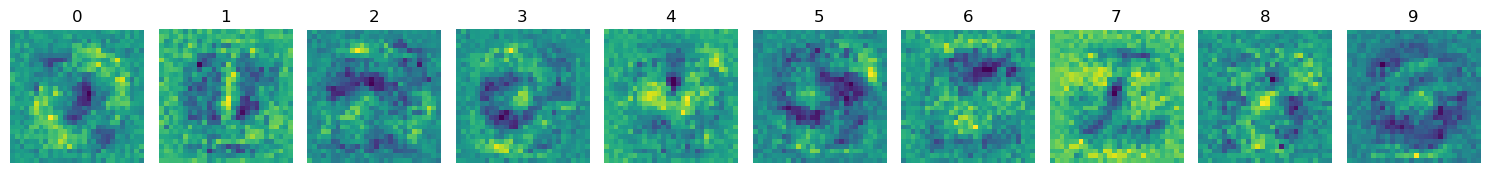

Iteration 40000 current batch loss: 0.012622611597180367
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.997092, 0.996912, 0.99797, 0.997969, 0.997206, 0.998424, 0.997534, 0.998227, 0.996376, 0.996342]


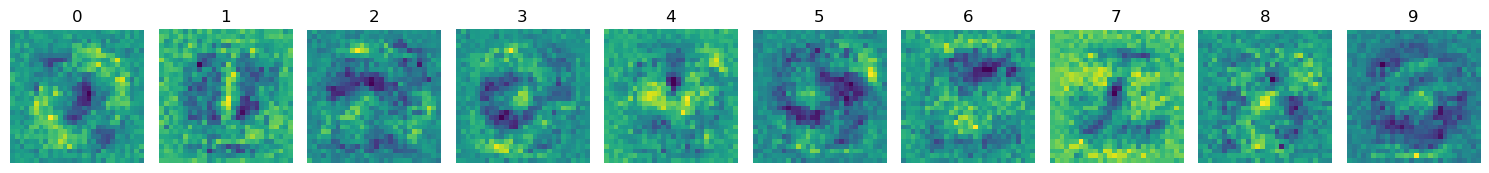

Iteration 40000 current batch loss: 0.012622611597180367


In [16]:
points = train_input(net, lambda_l2 = 1, plot = True)

Iteration 2000 current batch loss: 0.8493063449859619
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.971918, 0.967196, 0.981713, 0.97968, 0.973738, 0.983892, 0.973203, 0.984202, 0.963535, 0.961046]


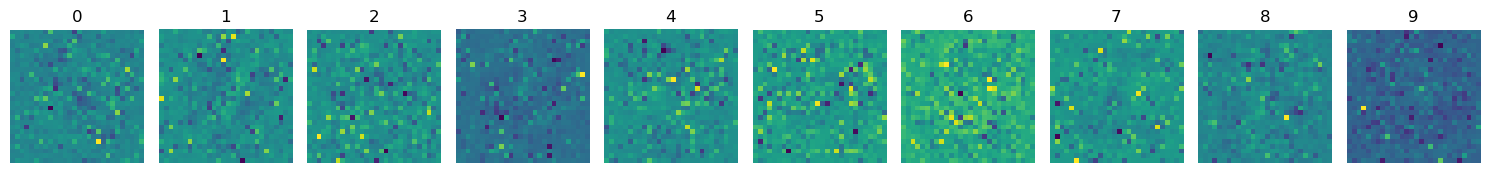

Iteration 4000 current batch loss: 0.0961538776755333
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.977548, 0.977331, 0.984672, 0.984913, 0.978319, 0.987824, 0.980678, 0.987146, 0.972956, 0.972019]


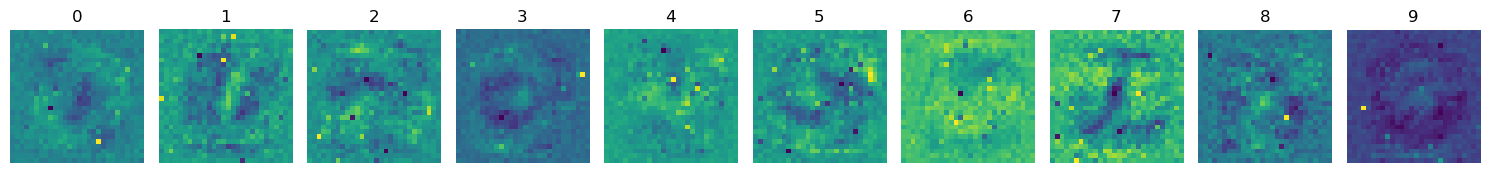

Iteration 6000 current batch loss: 0.07433323562145233
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.978614, 0.978283, 0.984976, 0.985081, 0.980001, 0.988224, 0.981808, 0.987336, 0.973399, 0.973647]


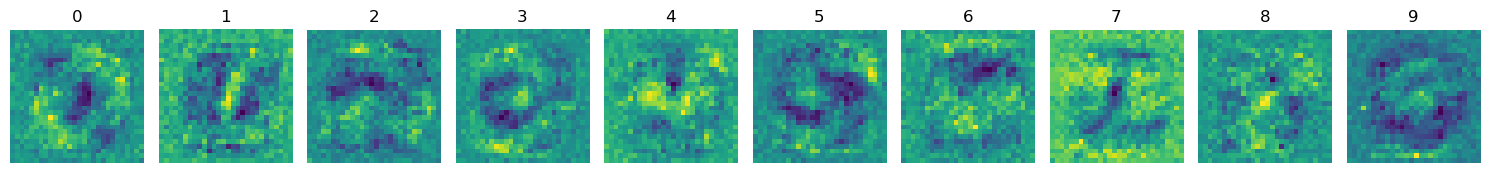

Iteration 8000 current batch loss: 0.07413072139024734
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.978669, 0.978305, 0.984998, 0.985083, 0.98014, 0.988234, 0.981816, 0.987331, 0.973418, 0.973723]


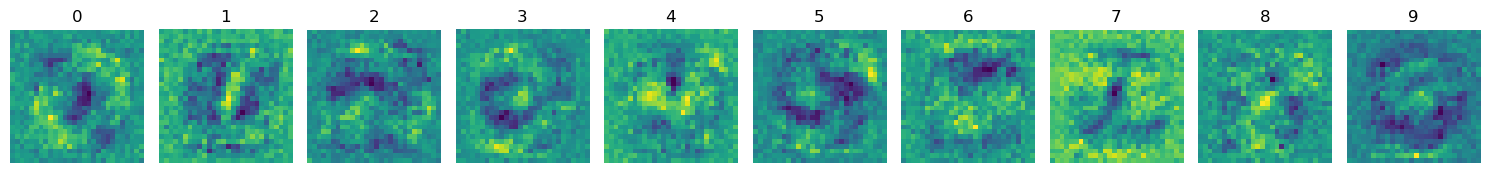

Iteration 10000 current batch loss: 0.07413633167743683
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.978669, 0.978312, 0.985021, 0.985079, 0.98016, 0.988245, 0.981806, 0.987336, 0.97341, 0.973732]


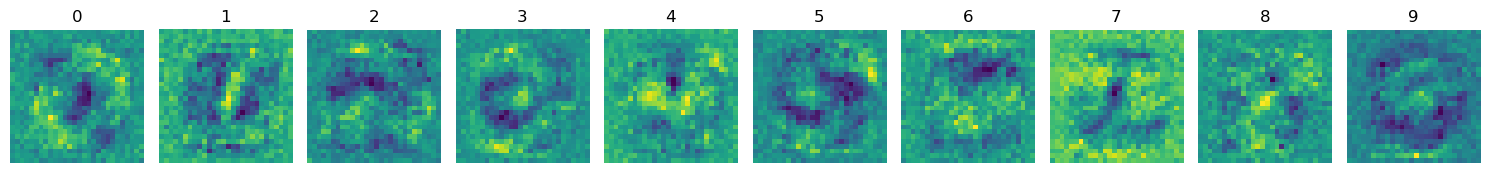

Iteration 12000 current batch loss: 0.07413629442453384
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.97865, 0.978298, 0.984995, 0.985074, 0.98017, 0.988232, 0.981821, 0.987327, 0.973419, 0.973732]


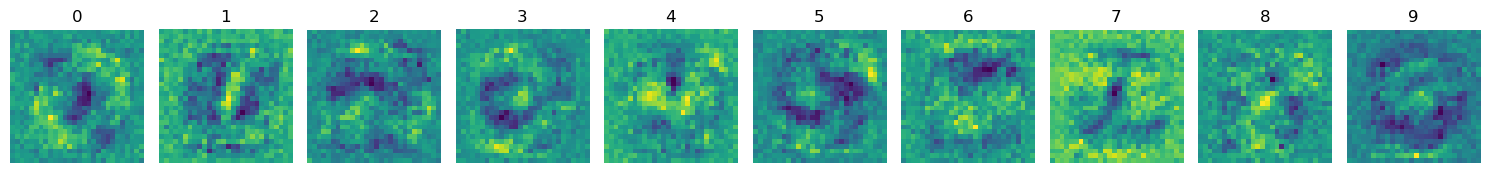

Iteration 14000 current batch loss: 0.07413250207901001
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.978667, 0.978301, 0.984998, 0.985085, 0.980178, 0.988216, 0.98187, 0.987324, 0.973433, 0.973726]


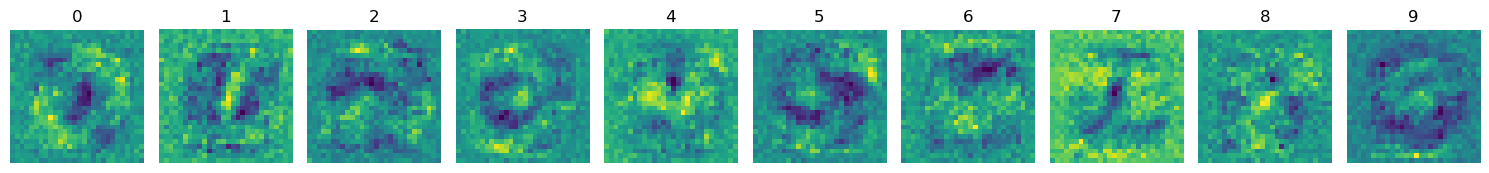

Iteration 16000 current batch loss: 0.07413258403539658
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.978671, 0.978287, 0.985004, 0.98508, 0.980165, 0.988228, 0.981837, 0.987345, 0.973416, 0.973737]


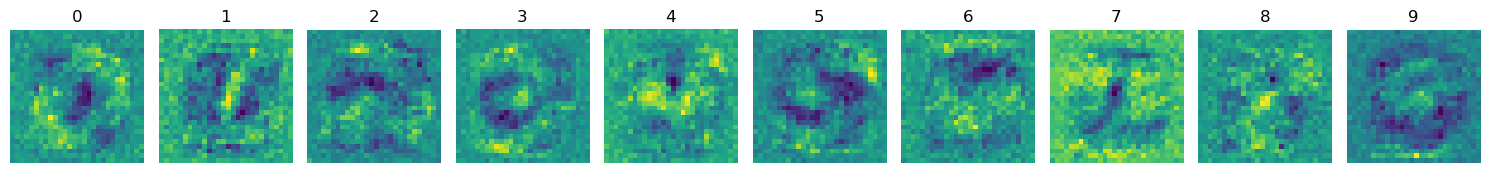

Iteration 18000 current batch loss: 0.07413699477910995
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.978663, 0.978308, 0.984996, 0.98508, 0.980149, 0.988213, 0.981827, 0.98735, 0.973407, 0.9737]


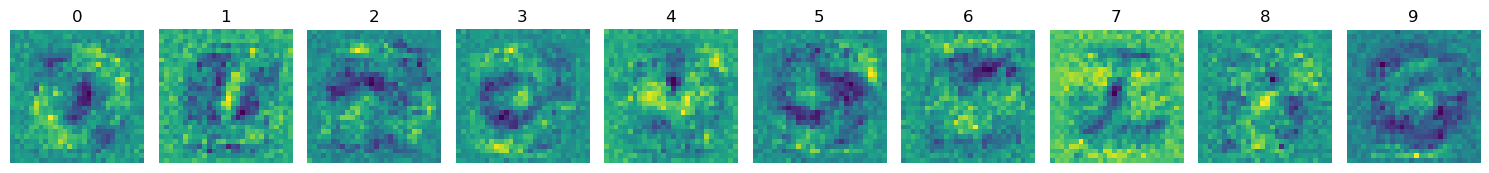

Iteration 20000 current batch loss: 0.0741327628493309
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.97866, 0.978295, 0.985001, 0.985081, 0.980172, 0.988227, 0.981847, 0.987332, 0.973397, 0.97374]


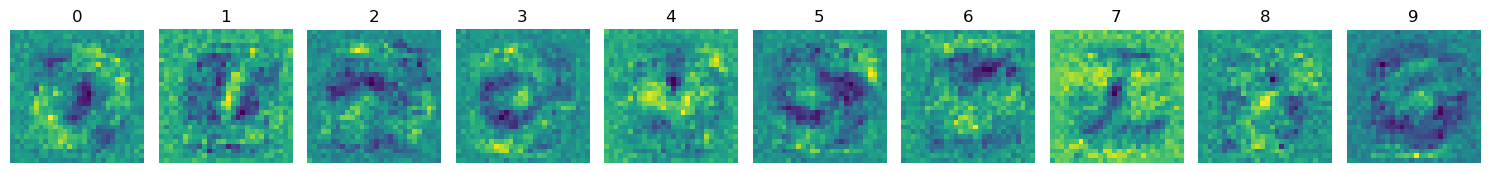

Iteration 22000 current batch loss: 0.0741332620382309
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.978684, 0.978293, 0.985002, 0.985066, 0.980192, 0.988239, 0.981843, 0.987349, 0.973422, 0.973722]


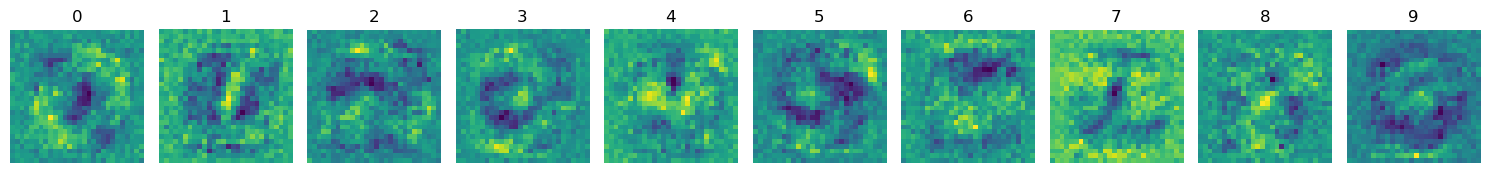

Iteration 24000 current batch loss: 0.07413314282894135
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.978683, 0.978291, 0.985008, 0.985067, 0.980171, 0.988237, 0.981842, 0.98734, 0.973416, 0.973728]


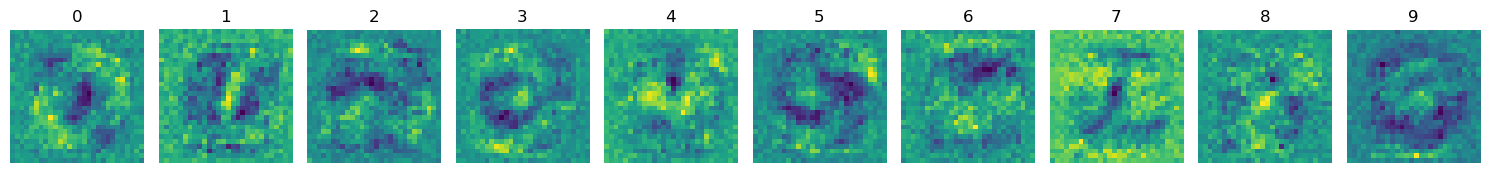

Iteration 26000 current batch loss: 0.07413499057292938
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.978644, 0.978303, 0.985006, 0.985072, 0.980152, 0.988227, 0.981824, 0.987344, 0.973412, 0.973699]


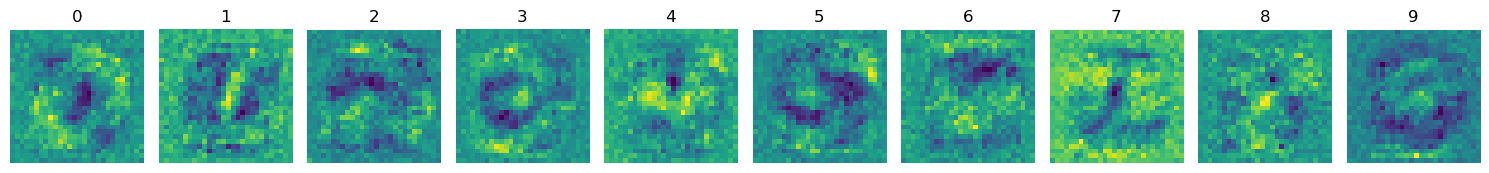

Iteration 28000 current batch loss: 0.07413502782583237
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.978663, 0.978298, 0.98501, 0.985077, 0.98018, 0.988229, 0.981842, 0.987329, 0.9734, 0.973715]


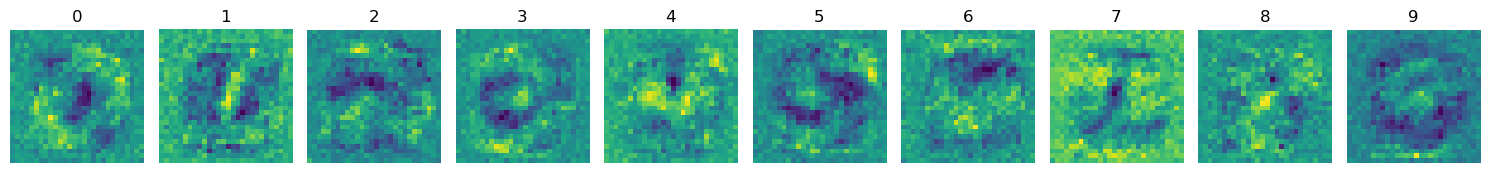

Iteration 30000 current batch loss: 0.07413320988416672
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.978672, 0.978298, 0.985, 0.985079, 0.980138, 0.98822, 0.981864, 0.98735, 0.973424, 0.97373]


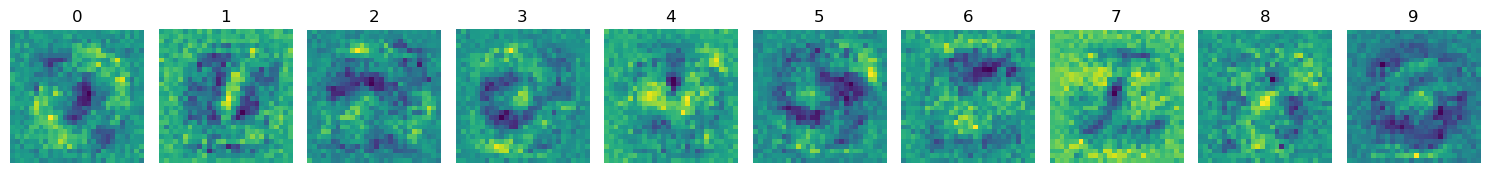

Iteration 32000 current batch loss: 0.07413463294506073
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.978657, 0.97831, 0.984998, 0.985083, 0.980159, 0.988241, 0.981836, 0.987323, 0.973432, 0.973747]


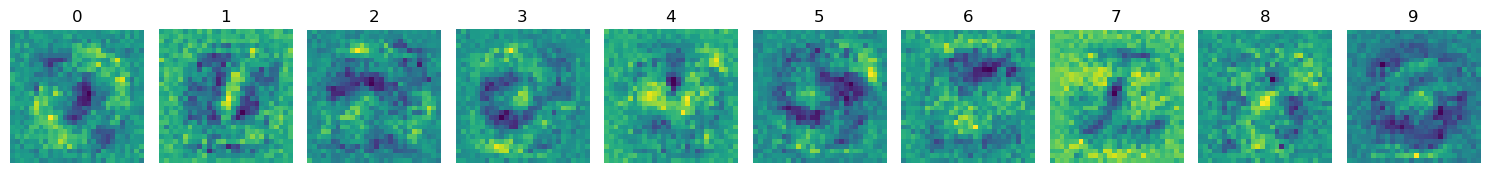

Iteration 34000 current batch loss: 0.07413382083177567
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.978652, 0.978288, 0.985011, 0.985068, 0.980148, 0.988227, 0.981852, 0.987345, 0.973411, 0.973747]


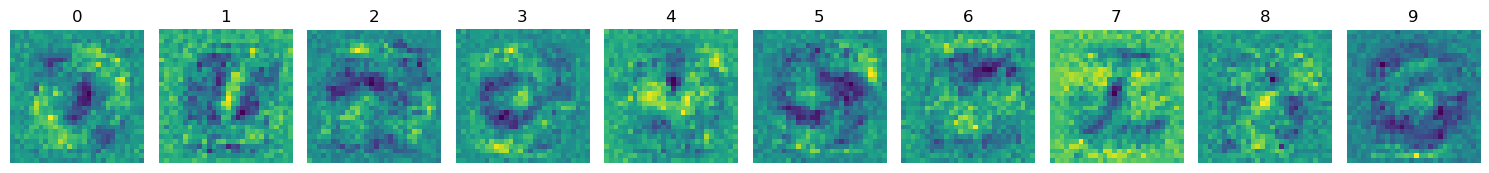

Iteration 36000 current batch loss: 0.07413433492183685
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.978685, 0.978293, 0.985, 0.98508, 0.980146, 0.988226, 0.981858, 0.987305, 0.973423, 0.973737]


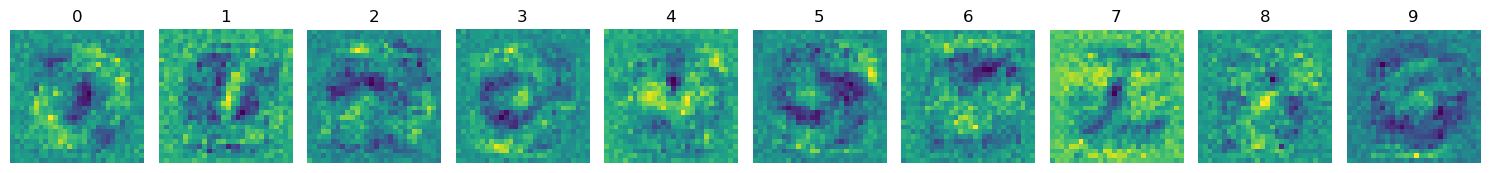

Iteration 38000 current batch loss: 0.07413305342197418
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.978662, 0.978308, 0.98501, 0.985085, 0.98018, 0.988219, 0.981855, 0.987324, 0.973404, 0.973713]


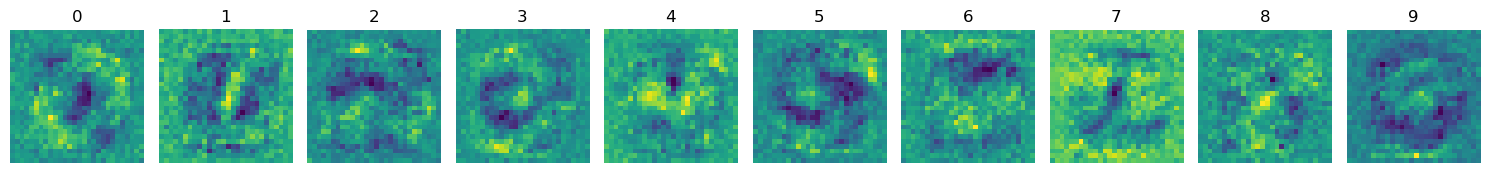

Iteration 40000 current batch loss: 0.07413303852081299
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.978648, 0.978298, 0.985001, 0.985077, 0.980203, 0.988229, 0.981846, 0.98732, 0.973418, 0.973723]


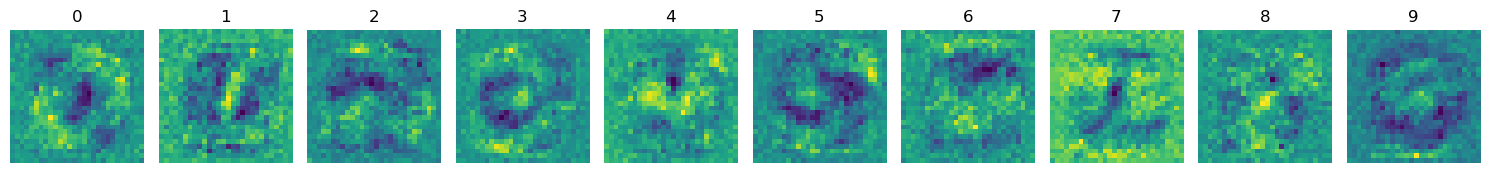

Iteration 40000 current batch loss: 0.07413303852081299


In [17]:
points = train_input(net, lambda_l2 = 10, plot = True)

In [18]:
print("the end!")

the end!


In [19]:
def plot_similar_numbers(points):

    img = points.squeeze().detach().cpu().numpy()
    pyplot.imshow(img)                 
    pyplot.tight_layout()
    pyplot.show()

def train_input_similar_numbers(net, numbers, lambda_l2 = 0, lr = 0.001, plot = False, info = 2000, max_iter = 40000):
    for parameters in net.parameters():
        parameters.requires_grad = False
    
    points = torch.randn(1, 1, 28, 28).to(device)
    points.requires_grad = True
        
    optimizer = torch.optim.Adam([points], lr)   #initial and fixed learning rate of 0.001.

    epoch = 0
    
    while epoch < max_iter:
    
        loss = 0
        optimizer.zero_grad()
        preds = net(points)
        for number in numbers:
            true = torch.tensor([number], dtype=torch.long, device=device)
            loss += torch.nn.functional.cross_entropy(preds, true, reduction = "mean") + lambda_l2 * points.pow(2).mean()
    
        epoch += 1
        if epoch % info == 0:
            print("Iteration", epoch, "current batch loss:", loss.item())
            preds_list = torch.nn.functional.softmax(net(points), dim = 1).tolist()[0]
            print("Predicted probabilities: ", [round(pred, 6) for pred in preds_list])
            if plot:
                plot_similar_numbers(points)
        
        loss.backward()     
        optimizer.step()     

    print("Iteration", epoch, "current batch loss:", loss.item())
    return points

Iteration 2000 current batch loss: 1.3911710977554321
Predicted probabilities:  [0.499468, 0.000113, 0.000537, 6.9e-05, 2.8e-05, 0.00011, 0.000143, 0.000149, 0.499193, 0.000189]


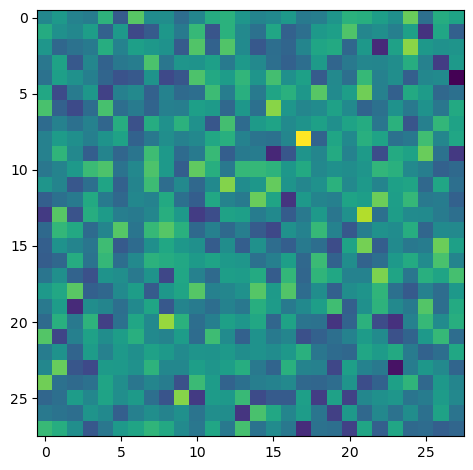

Iteration 4000 current batch loss: 1.3891607522964478
Predicted probabilities:  [0.499873, 2.9e-05, 0.000124, 1.1e-05, 6e-06, 2.2e-05, 4.4e-05, 3.5e-05, 0.499806, 4.9e-05]


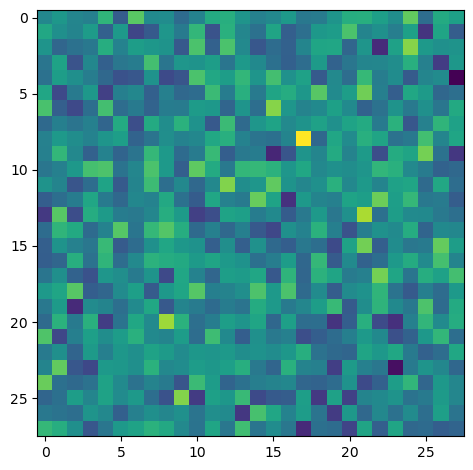

Iteration 6000 current batch loss: 1.3886953592300415
Predicted probabilities:  [0.499954, 1.1e-05, 4.2e-05, 3e-06, 2e-06, 7e-06, 1.8e-05, 1.2e-05, 0.499936, 1.6e-05]


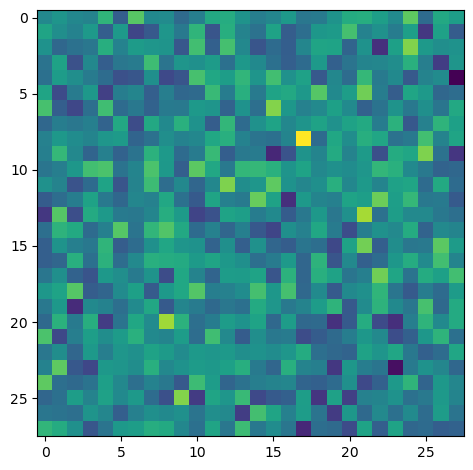

Iteration 8000 current batch loss: 1.3884087800979614
Predicted probabilities:  [0.500044, 5e-06, 1.9e-05, 1e-06, 1e-06, 3e-06, 9e-06, 5e-06, 0.499906, 8e-06]


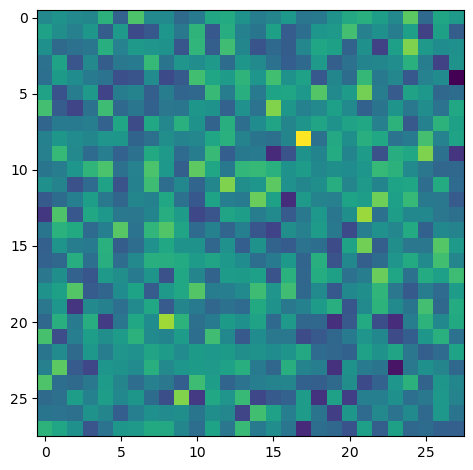

Iteration 10000 current batch loss: 1.3881134986877441
Predicted probabilities:  [0.500451, 3e-06, 1.2e-05, 1e-06, 0.0, 1e-06, 7e-06, 3e-06, 0.499516, 5e-06]


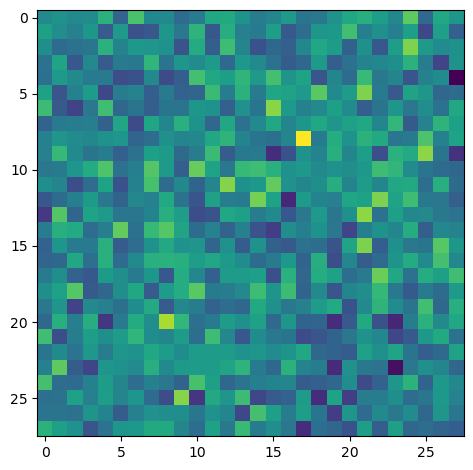

Iteration 12000 current batch loss: 1.3878276348114014
Predicted probabilities:  [0.500048, 3e-06, 9e-06, 0.0, 0.0, 1e-06, 6e-06, 2e-06, 0.499927, 4e-06]


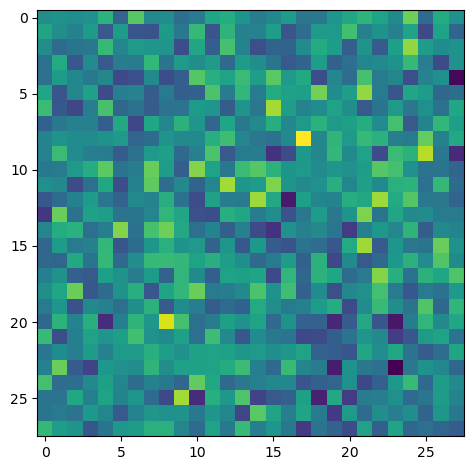

Iteration 14000 current batch loss: 1.3875914812088013
Predicted probabilities:  [0.499985, 2e-06, 7e-06, 0.0, 0.0, 1e-06, 5e-06, 2e-06, 0.499993, 4e-06]


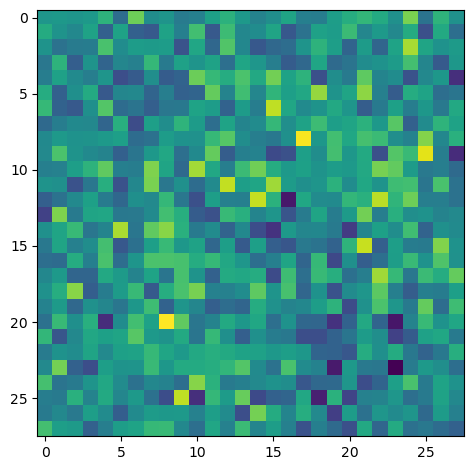

Iteration 16000 current batch loss: 1.3874223232269287
Predicted probabilities:  [0.500695, 2e-06, 7e-06, 0.0, 0.0, 1e-06, 5e-06, 2e-06, 0.499284, 4e-06]


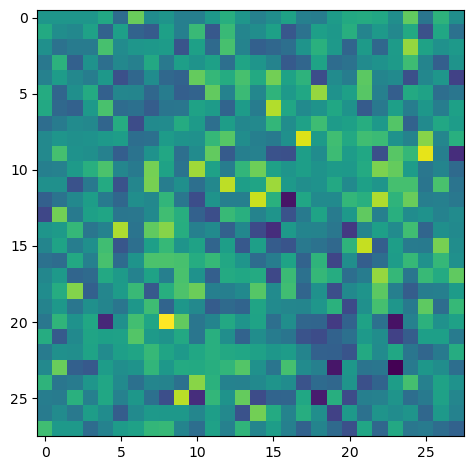

Iteration 18000 current batch loss: 1.3872913122177124
Predicted probabilities:  [0.499958, 2e-06, 6e-06, 0.0, 0.0, 1e-06, 5e-06, 2e-06, 0.500022, 4e-06]


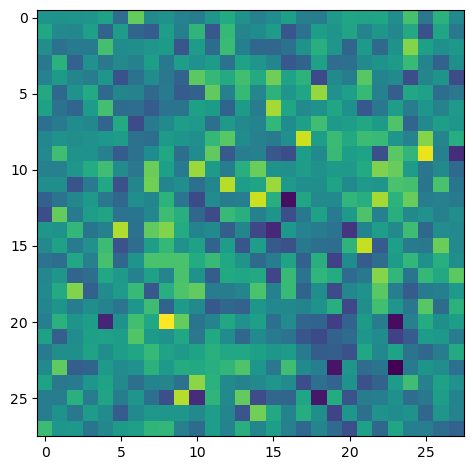

Iteration 20000 current batch loss: 1.3872175216674805
Predicted probabilities:  [0.502389, 2e-06, 6e-06, 0.0, 0.0, 1e-06, 5e-06, 1e-06, 0.497591, 4e-06]


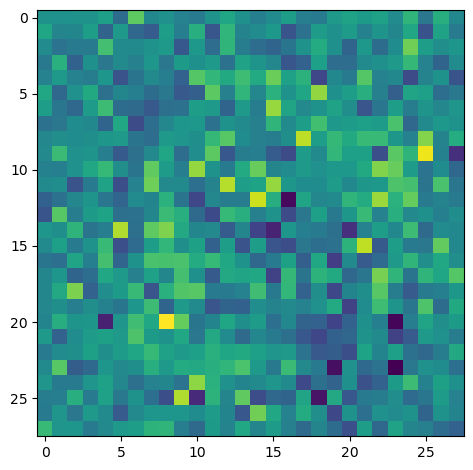

Iteration 22000 current batch loss: 1.387117862701416
Predicted probabilities:  [0.500022, 2e-06, 6e-06, 0.0, 0.0, 1e-06, 5e-06, 1e-06, 0.499959, 4e-06]


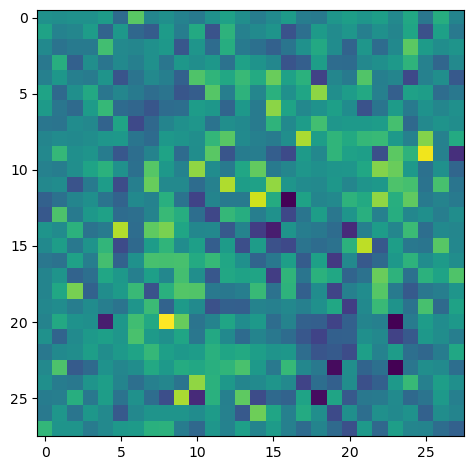

Iteration 24000 current batch loss: 1.3870530128479004
Predicted probabilities:  [0.500006, 2e-06, 6e-06, 0.0, 0.0, 1e-06, 5e-06, 1e-06, 0.499976, 4e-06]


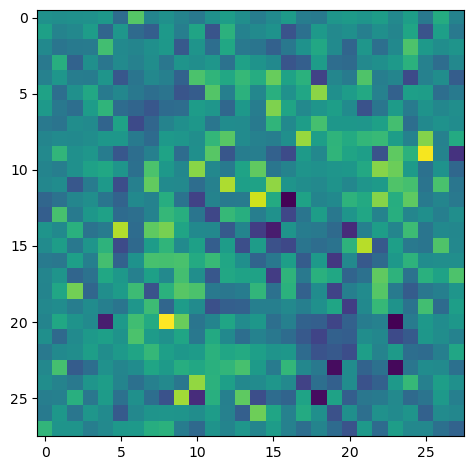

Iteration 26000 current batch loss: 1.3869972229003906
Predicted probabilities:  [0.499994, 2e-06, 6e-06, 0.0, 0.0, 1e-06, 4e-06, 1e-06, 0.499988, 4e-06]


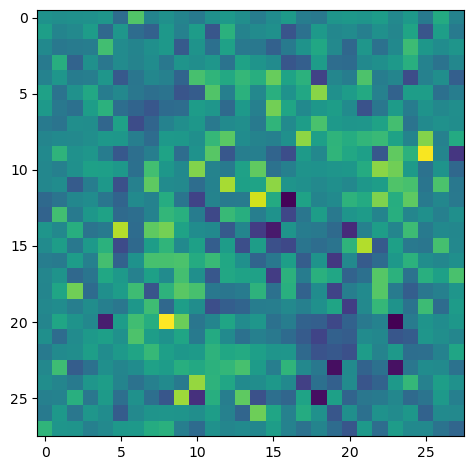

Iteration 28000 current batch loss: 1.3869532346725464
Predicted probabilities:  [0.499224, 2e-06, 6e-06, 0.0, 0.0, 1e-06, 4e-06, 1e-06, 0.500758, 4e-06]


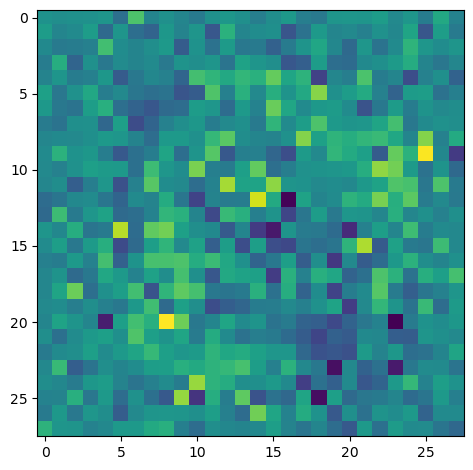

Iteration 30000 current batch loss: 1.3869110345840454
Predicted probabilities:  [0.499867, 2e-06, 6e-06, 0.0, 0.0, 1e-06, 4e-06, 1e-06, 0.500116, 4e-06]


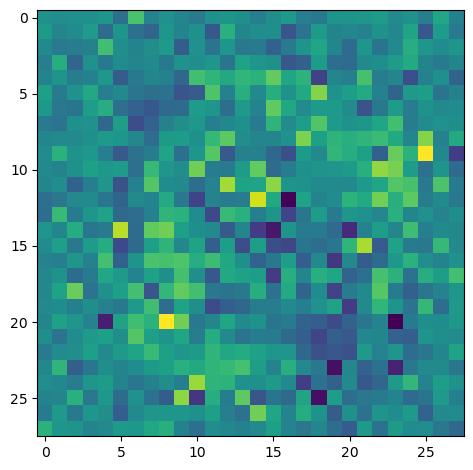

Iteration 32000 current batch loss: 1.3868759870529175
Predicted probabilities:  [0.500259, 1e-06, 6e-06, 0.0, 0.0, 1e-06, 4e-06, 1e-06, 0.499724, 3e-06]


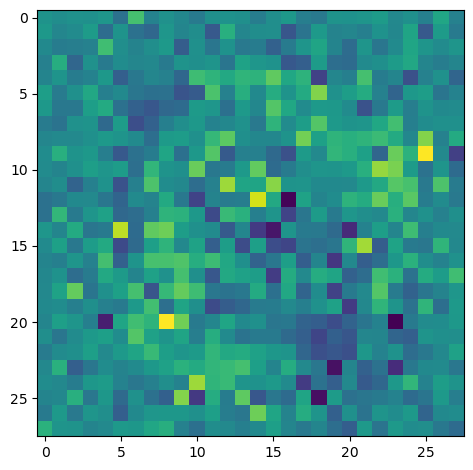

Iteration 34000 current batch loss: 1.3868454694747925
Predicted probabilities:  [0.499733, 1e-06, 6e-06, 0.0, 0.0, 1e-06, 4e-06, 1e-06, 0.50025, 3e-06]


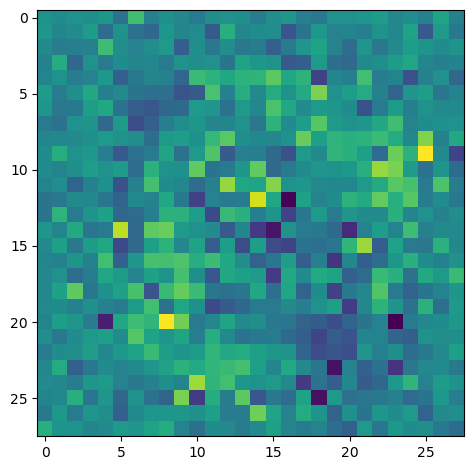

Iteration 36000 current batch loss: 1.386818528175354
Predicted probabilities:  [0.499994, 1e-06, 6e-06, 0.0, 0.0, 1e-06, 4e-06, 1e-06, 0.499989, 3e-06]


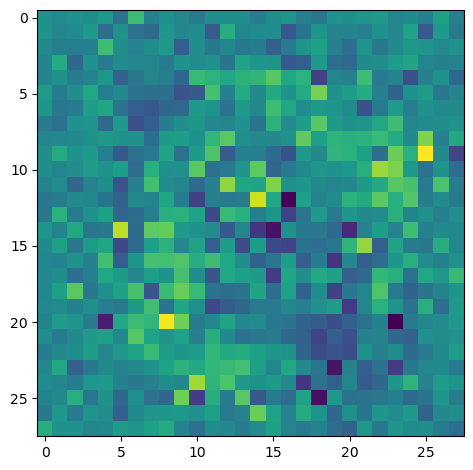

Iteration 38000 current batch loss: 1.3867948055267334
Predicted probabilities:  [0.499805, 1e-06, 6e-06, 0.0, 0.0, 1e-06, 4e-06, 1e-06, 0.500177, 3e-06]


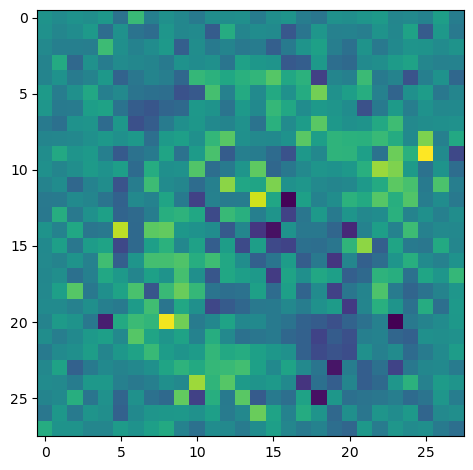

Iteration 40000 current batch loss: 1.3867733478546143
Predicted probabilities:  [0.500039, 1e-06, 6e-06, 0.0, 0.0, 1e-06, 4e-06, 1e-06, 0.499944, 3e-06]


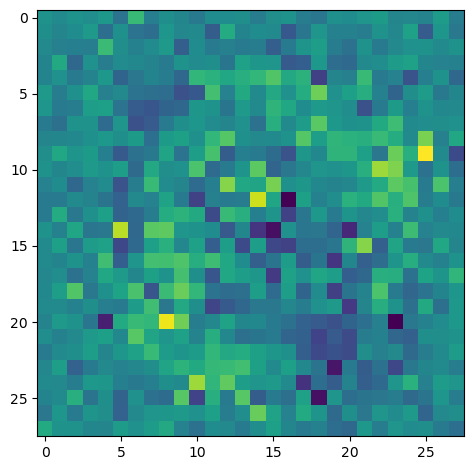

Iteration 40000 current batch loss: 1.3867733478546143


In [20]:
points = train_input_similar_numbers(net, [0, 8], lambda_l2 = 0.001, plot = True)

In [21]:
print("the end!")

the end!
